In [1]:
import re
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna.integration.lightgbm as lgb

In [2]:
all_new = pd.read_csv('data/feature_df.csv')
wordvec_df = pd.read_csv('sub_notebook/data/wordvectorized_df.csv')
bert_embeded = pd.read_csv('kaggle-notebook/data/bert_embeded.csv')
#tfidf_1000 = pd.read_csv('data/tfidf_1000.csv')
tfidf_svd_raw_64 = pd.read_csv("data/tfidf_svd_raw_64.csv")
#tfidf_svd_content_64 = pd.read_csv("data/tfidf_svd_content_64.csv")
#tfidf_svd_compiled_64 = pd.read_csv("data/tfidf_svd_compiled_64.csv")
mfw_df = pd.read_csv('data/mfw.csv')
miw_df = pd.read_csv('data/miw.csv')

In [3]:
all_new = pd.merge(all_new, bert_embeded, on="id", how="outer")
all_new = pd.merge(all_new, tfidf_svd_raw_64, on="id", how="outer")
all_new = pd.merge(all_new, wordvec_df, on="id", how="outer")
all_new = pd.merge(all_new, miw_df, on="id", how="outer")
all_new = pd.merge(all_new, mfw_df.drop(["mfw", "sfw"], axis=1), on="id", how="outer")

In [4]:
test_data = all_new[all_new["data_type"] == "test"]
train_data = all_new[all_new["data_type"] == "train"]

In [5]:
def read_json(path):
    with open(path) as f:
        json_dict = json.load(f)
    return json_dict


def get_trained_results(json_paths):
    oofs = []
    preds = []
    for json_path in json_paths:
        json_dict = read_json(json_path)
        oof = json_dict["out_of_fold"]
        pred = json_dict["prediction"]
        oofs.append(oof)
        preds.append(pred)
        json_dict.clear()
    return oofs, preds

In [6]:
oofs, preds = get_trained_results(json_paths=[
    "data/nn_config_svd64_raw.json",
    "data/lgbm_config_svd64_raw.json",
    "data/lgbm_config_bert.json",
    "data/rf_config_svd64_raw.json",
    "data/lgbm_config_bert_svd64_raw.json",
    "data/lgbm_config_bert128_svd64_raw.json",
])

In [23]:
def get_danger_vector(oofs, label):
    
    threshold = 0.4
    oofs = np.array(oofs)
    label = np.array(label)
    diffs = []
    for oof in oofs:
        oof = np.where(oof < threshold, 0, 1)
        diff = label - oof
        diff = np.power(diff.astype(int), 2)
        diffs.append(diff)
    danger_vector = sum(diffs)
    return danger_vector

In [24]:
dang_vec = get_danger_vector(oofs, train_data["state"])
dang_vec

array([1, 0, 2, ..., 0, 0, 0])

<AxesSubplot:>

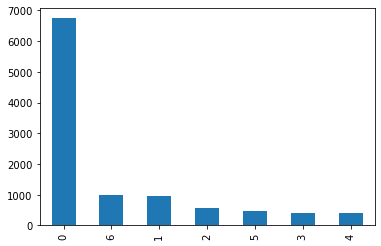

In [29]:
dang_df = pd.DataFrame({"danger": dang_vec})
dang_df.danger.value_counts().plot(kind="bar")

In [34]:
danger_df = train_data[dang_df["danger"] > 1]

In [32]:
def check_distribution(train):
    plt.figure(figsize=(12,12))

    plt.subplot(3,3,1)
    plt.title('state(target)')
    try:
        train.state.value_counts().plot(kind='bar')
    except:
        pass

    plt.subplot(3,3,2)
    plt.title('country')
    train.country.value_counts().plot(kind='bar')

    plt.subplot(3,3,3)
    plt.title('duration(top20)')
    train.duration.value_counts()[:20].plot(kind='bar')

    plt.subplot(3,3,4)
    plt.title('category1')
    train.category1.value_counts().plot(kind='bar')

    plt.subplot(3,3,5)
    plt.title('category2(top20)')
    train.category2.value_counts()[:20].plot(kind='bar')

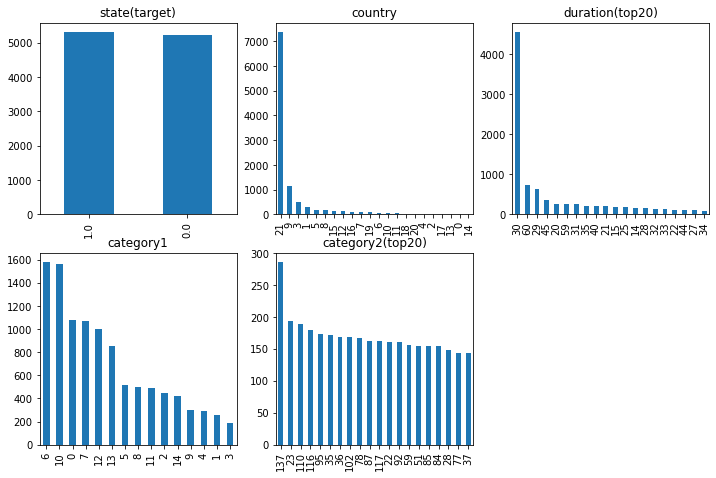

In [33]:
check_distribution(train_data)

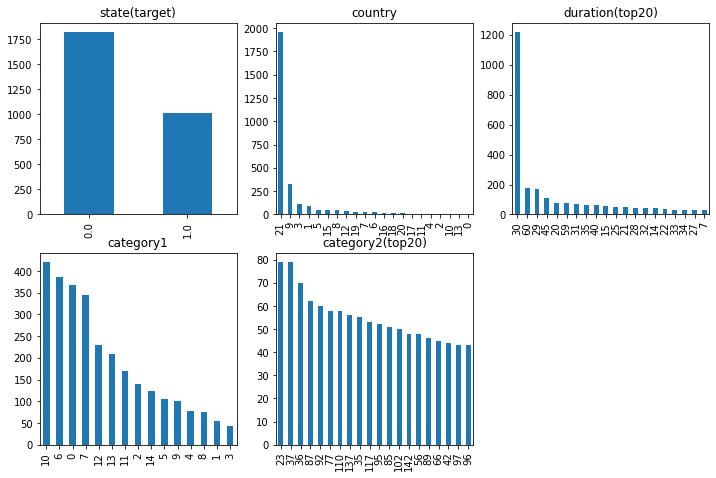

In [35]:
check_distribution(danger_df)

In [42]:
def run_optuna_lgbm(test, train, target_cols, feature_cols, categorical_cols, seed):
    """
    import optuna.integration.lightgbm as lgb
    """
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    importances = []
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train.loc[train_index]
        y_val = y_train.loc[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=False,
                          num_boost_round=1000,
                          early_stopping_rounds=20,
                          )
        
        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
        
        # display importance
        importance = pd.DataFrame(model.feature_importance(), index=feature_cols, columns=['importance'])
        display(importance)
        importances.append(importance)

    return oof_train, sum(y_preds) / len(y_preds), importances

In [43]:
with open("data/lgbm_config_svd64_raw.json") as f:
    optuna_config_dict = json.load(f)

feature_cols = optuna_config_dict["selected_feature"]
CATEGORICAL_COLS = [
    "country",
    "category1",
    "category2",
    "country+category1",
    "country+category2",
    "category1+category2",
]

for categorical_col in set(CATEGORICAL_COLS):
    if categorical_col not in feature_cols:
        CATEGORICAL_COLS.remove(categorical_col)

        
params = {
        'objective': 'regression',
        'metric': 'rmse',
    }

oof, pred, importances = run_optuna_lgbm(test_data, pd.concat([train_data, dang_df], axis=1), ["danger"], feature_cols, CATEGORICAL_COLS, 123)

[I 2021-01-27 00:11:59,182] A new study created in memory with name: no-name-f007b02e-573c-4095-b4c4-1b466d1fcf4c


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.879827:   0%|          | 0/7 [00:01<?, ?it/s]

feature_fraction, val_score: 1.879827:  14%|#4        | 1/7 [00:01<00:07,  1.32s/it][I 2021-01-27 00:12:00,524] Trial 0 finished with value: 1.8798268076921196 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 1.8798268076921196.


feature_fraction, val_score: 1.879827:  14%|#4        | 1/7 [00:01<00:07,  1.32s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.879827:  14%|#4        | 1/7 [00:02<00:07,  1.32s/it]

feature_fraction, val_score: 1.879827:  29%|##8       | 2/7 [00:02<00:06,  1.31s/it][I 2021-01-27 00:12:01,808] Trial 1 finished with value: 1.8948370764714773 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 1.8798268076921196.


feature_fraction, val_score: 1.879827:  29%|##8       | 2/7 [00:02<00:06,  1.31s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.879827:  29%|##8       | 2/7 [00:04<00:06,  1.31s/it]

feature_fraction, val_score: 1.879827:  43%|####2     | 3/7 [00:04<00:05,  1.46s/it][I 2021-01-27 00:12:03,594] Trial 2 finished with value: 1.901005807748436 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 1.8798268076921196.


feature_fraction, val_score: 1.879827:  43%|####2     | 3/7 [00:04<00:05,  1.46s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.879827:  43%|####2     | 3/7 [00:06<00:05,  1.46s/it]

feature_fraction, val_score: 1.879827:  57%|#####7    | 4/7 [00:06<00:05,  1.69s/it][I 2021-01-27 00:12:05,832] Trial 3 finished with value: 1.8856604017304441 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 1.8798268076921196.


feature_fraction, val_score: 1.879827:  57%|#####7    | 4/7 [00:06<00:05,  1.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.879827:  57%|#####7    | 4/7 [00:08<00:05,  1.69s/it]

feature_fraction, val_score: 1.879827:  71%|#######1  | 5/7 [00:08<00:03,  1.78s/it][I 2021-01-27 00:12:07,829] Trial 4 finished with value: 1.8955761149585497 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 1.8798268076921196.


feature_fraction, val_score: 1.879827:  71%|#######1  | 5/7 [00:08<00:03,  1.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.879827:  71%|#######1  | 5/7 [00:09<00:03,  1.78s/it]

feature_fraction, val_score: 1.879827:  86%|########5 | 6/7 [00:09<00:01,  1.64s/it][I 2021-01-27 00:12:09,125] Trial 5 finished with value: 1.8909035864934975 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 1.8798268076921196.


feature_fraction, val_score: 1.879827:  86%|########5 | 6/7 [00:09<00:01,  1.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.877535:  86%|########5 | 6/7 [00:11<00:01,  1.64s/it]

feature_fraction, val_score: 1.877535: 100%|##########| 7/7 [00:11<00:00,  1.59s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 1.877535:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:   0%|          | 0/20 [00:04<?, ?it/s]

num_leaves, val_score: 1.877535:   5%|5         | 1/20 [00:04<01:28,  4.64s/it][I 2021-01-27 00:12:14,972] Trial 7 finished with value: 1.887984726925151 and parameters: {'num_leaves': 120}. Best is trial 7 with value: 1.887984726925151.


num_leaves, val_score: 1.877535:   5%|5         | 1/20 [00:04<01:28,  4.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:   5%|5         | 1/20 [00:09<01:28,  4.64s/it]

num_leaves, val_score: 1.877535:  10%|#         | 2/20 [00:09<01:26,  4.79s/it][I 2021-01-27 00:12:20,122] Trial 8 finished with value: 1.8976472279576102 and parameters: {'num_leaves': 250}. Best is trial 7 with value: 1.887984726925151.


num_leaves, val_score: 1.877535:  10%|#         | 2/20 [00:09<01:26,  4.79s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  10%|#         | 2/20 [00:11<01:26,  4.79s/it]

num_leaves, val_score: 1.877535:  15%|#5        | 3/20 [00:11<01:03,  3.74s/it][I 2021-01-27 00:12:21,416] Trial 9 finished with value: 1.8978313197816727 and parameters: {'num_leaves': 161}. Best is trial 7 with value: 1.887984726925151.


num_leaves, val_score: 1.877535:  15%|#5        | 3/20 [00:11<01:03,  3.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  15%|#5        | 3/20 [00:12<01:03,  3.74s/it]

num_leaves, val_score: 1.877535:  20%|##        | 4/20 [00:12<00:47,  2.98s/it][I 2021-01-27 00:12:22,633] Trial 10 finished with value: 1.8820677213973944 and parameters: {'num_leaves': 19}. Best is trial 10 with value: 1.8820677213973944.


num_leaves, val_score: 1.877535:  20%|##        | 4/20 [00:12<00:47,  2.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  20%|##        | 4/20 [00:14<00:47,  2.98s/it]

num_leaves, val_score: 1.877535:  25%|##5       | 5/20 [00:14<00:41,  2.75s/it][I 2021-01-27 00:12:24,837] Trial 11 finished with value: 1.880985915767475 and parameters: {'num_leaves': 27}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  25%|##5       | 5/20 [00:14<00:41,  2.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  25%|##5       | 5/20 [00:19<00:41,  2.75s/it]

num_leaves, val_score: 1.877535:  30%|###       | 6/20 [00:19<00:48,  3.49s/it][I 2021-01-27 00:12:30,039] Trial 12 finished with value: 1.9023059207905229 and parameters: {'num_leaves': 253}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  30%|###       | 6/20 [00:19<00:48,  3.49s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  30%|###       | 6/20 [00:24<00:48,  3.49s/it]

num_leaves, val_score: 1.877535:  35%|###5      | 7/20 [00:24<00:49,  3.77s/it][I 2021-01-27 00:12:34,483] Trial 13 finished with value: 1.9072109795129029 and parameters: {'num_leaves': 108}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  35%|###5      | 7/20 [00:24<00:49,  3.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  35%|###5      | 7/20 [00:38<00:49,  3.77s/it]

num_leaves, val_score: 1.877535:  40%|####      | 8/20 [00:38<01:21,  6.83s/it][I 2021-01-27 00:12:48,442] Trial 14 finished with value: 1.890461554871733 and parameters: {'num_leaves': 187}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  40%|####      | 8/20 [00:38<01:21,  6.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  40%|####      | 8/20 [00:39<01:21,  6.83s/it]

num_leaves, val_score: 1.877535:  45%|####5     | 9/20 [00:39<00:56,  5.16s/it][I 2021-01-27 00:12:49,721] Trial 15 finished with value: 1.8823725664020945 and parameters: {'num_leaves': 59}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  45%|####5     | 9/20 [00:39<00:56,  5.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  45%|####5     | 9/20 [00:43<00:56,  5.16s/it]

num_leaves, val_score: 1.877535:  50%|#####     | 10/20 [00:43<00:49,  4.90s/it][I 2021-01-27 00:12:54,020] Trial 16 finished with value: 1.8976742425376827 and parameters: {'num_leaves': 201}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  50%|#####     | 10/20 [00:43<00:49,  4.90s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  50%|#####     | 10/20 [00:44<00:49,  4.90s/it]

num_leaves, val_score: 1.877535:  55%|#####5    | 11/20 [00:44<00:33,  3.68s/it][I 2021-01-27 00:12:54,848] Trial 17 finished with value: 1.881084324772805 and parameters: {'num_leaves': 75}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  55%|#####5    | 11/20 [00:44<00:33,  3.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  55%|#####5    | 11/20 [00:49<00:33,  3.68s/it]

num_leaves, val_score: 1.877535:  60%|######    | 12/20 [00:49<00:32,  4.03s/it][I 2021-01-27 00:12:59,708] Trial 18 finished with value: 1.8895329256354545 and parameters: {'num_leaves': 219}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  60%|######    | 12/20 [00:49<00:32,  4.03s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  60%|######    | 12/20 [00:50<00:32,  4.03s/it]

num_leaves, val_score: 1.877535:  65%|######5   | 13/20 [00:50<00:21,  3.05s/it][I 2021-01-27 00:13:00,449] Trial 19 finished with value: 1.920327474201649 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  65%|######5   | 13/20 [00:50<00:21,  3.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  65%|######5   | 13/20 [00:56<00:21,  3.05s/it]

num_leaves, val_score: 1.877535:  70%|#######   | 14/20 [00:56<00:24,  4.15s/it][I 2021-01-27 00:13:07,171] Trial 20 finished with value: 1.8856910549027663 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  70%|#######   | 14/20 [00:56<00:24,  4.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  70%|#######   | 14/20 [00:58<00:24,  4.15s/it]

num_leaves, val_score: 1.877535:  75%|#######5  | 15/20 [00:58<00:16,  3.36s/it][I 2021-01-27 00:13:08,700] Trial 21 finished with value: 1.8917934969020376 and parameters: {'num_leaves': 33}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  75%|#######5  | 15/20 [00:58<00:16,  3.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.877535:  75%|#######5  | 15/20 [01:01<00:16,  3.36s/it]

num_leaves, val_score: 1.877535:  80%|########  | 16/20 [01:01<00:13,  3.28s/it][I 2021-01-27 00:13:11,783] Trial 22 finished with value: 1.8889115492811237 and parameters: {'num_leaves': 85}. Best is trial 11 with value: 1.880985915767475.


num_leaves, val_score: 1.877535:  80%|########  | 16/20 [01:01<00:13,  3.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.873993:  80%|########  | 16/20 [01:02<00:13,  3.28s/it]

num_leaves, val_score: 1.873993:  85%|########5 | 17/20 [01:02<00:07,  2.61s/it][I 2021-01-27 00:13:12,838] Trial 23 finished with value: 1.8739932248554492 and parameters: {'num_leaves': 43}. Best is trial 23 with value: 1.8739932248554492.


num_leaves, val_score: 1.873993:  85%|########5 | 17/20 [01:02<00:07,  2.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.873993:  85%|########5 | 17/20 [01:03<00:07,  2.61s/it]

num_leaves, val_score: 1.873993:  90%|######### | 18/20 [01:03<00:04,  2.01s/it][I 2021-01-27 00:13:13,442] Trial 24 finished with value: 1.8876259098280428 and parameters: {'num_leaves': 48}. Best is trial 23 with value: 1.8739932248554492.


num_leaves, val_score: 1.873993:  90%|######### | 18/20 [01:03<00:04,  2.01s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.873993:  90%|######### | 18/20 [01:04<00:04,  2.01s/it]

num_leaves, val_score: 1.873993:  95%|#########5| 19/20 [01:04<00:01,  1.71s/it][I 2021-01-27 00:13:14,450] Trial 25 finished with value: 1.8900501857532699 and parameters: {'num_leaves': 94}. Best is trial 23 with value: 1.8739932248554492.


num_leaves, val_score: 1.873993:  95%|#########5| 19/20 [01:04<00:01,  1.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.873993:  95%|#########5| 19/20 [01:07<00:01,  1.71s/it]

num_leaves, val_score: 1.873993: 100%|##########| 20/20 [01:07<00:00,  3.36s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 1.873993:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:   0%|          | 0/10 [00:01<?, ?it/s]

bagging, val_score: 1.873993:  10%|#         | 1/10 [00:01<00:11,  1.31s/it][I 2021-01-27 00:13:18,914] Trial 27 finished with value: 1.8918179024848905 and parameters: {'bagging_fraction': 0.7627287556168554, 'bagging_freq': 6}. Best is trial 27 with value: 1.8918179024848905.


bagging, val_score: 1.873993:  10%|#         | 1/10 [00:01<00:11,  1.31s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:  10%|#         | 1/10 [00:02<00:11,  1.31s/it]

bagging, val_score: 1.873993:  20%|##        | 2/10 [00:02<00:09,  1.14s/it][I 2021-01-27 00:13:19,655] Trial 28 finished with value: 1.8999593498501803 and parameters: {'bagging_fraction': 0.407102789178354, 'bagging_freq': 1}. Best is trial 27 with value: 1.8918179024848905.


bagging, val_score: 1.873993:  20%|##        | 2/10 [00:02<00:09,  1.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:  20%|##        | 2/10 [00:02<00:09,  1.14s/it]

bagging, val_score: 1.873993:  30%|###       | 3/10 [00:02<00:06,  1.02it/s][I 2021-01-27 00:13:20,261] Trial 29 finished with value: 1.884444521627171 and parameters: {'bagging_fraction': 0.9954940283702287, 'bagging_freq': 1}. Best is trial 29 with value: 1.884444521627171.


bagging, val_score: 1.873993:  30%|###       | 3/10 [00:02<00:06,  1.02it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:  30%|###       | 3/10 [00:03<00:06,  1.02it/s]

bagging, val_score: 1.873993:  40%|####      | 4/10 [00:03<00:04,  1.22it/s][I 2021-01-27 00:13:20,696] Trial 30 finished with value: 1.9221313523275698 and parameters: {'bagging_fraction': 0.40096933846444527, 'bagging_freq': 7}. Best is trial 29 with value: 1.884444521627171.


bagging, val_score: 1.873993:  40%|####      | 4/10 [00:03<00:04,  1.22it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:  40%|####      | 4/10 [00:04<00:04,  1.22it/s]

bagging, val_score: 1.873993:  50%|#####     | 5/10 [00:04<00:05,  1.06s/it][I 2021-01-27 00:13:22,322] Trial 31 finished with value: 1.8884311169601302 and parameters: {'bagging_fraction': 0.6656279442848676, 'bagging_freq': 4}. Best is trial 29 with value: 1.884444521627171.


bagging, val_score: 1.873993:  50%|#####     | 5/10 [00:04<00:05,  1.06s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:  50%|#####     | 5/10 [00:06<00:05,  1.06s/it]

bagging, val_score: 1.873993:  60%|######    | 6/10 [00:06<00:05,  1.40s/it][I 2021-01-27 00:13:24,500] Trial 32 finished with value: 1.879931050974171 and parameters: {'bagging_fraction': 0.9912849761189488, 'bagging_freq': 4}. Best is trial 32 with value: 1.879931050974171.


bagging, val_score: 1.873993:  60%|######    | 6/10 [00:06<00:05,  1.40s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:  60%|######    | 6/10 [00:09<00:05,  1.40s/it]

bagging, val_score: 1.873993:  70%|#######   | 7/10 [00:09<00:05,  1.80s/it][I 2021-01-27 00:13:27,231] Trial 33 finished with value: 1.8892257655213656 and parameters: {'bagging_fraction': 0.9764966609696677, 'bagging_freq': 4}. Best is trial 32 with value: 1.879931050974171.


bagging, val_score: 1.873993:  70%|#######   | 7/10 [00:09<00:05,  1.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:  70%|#######   | 7/10 [00:12<00:05,  1.80s/it]

bagging, val_score: 1.873993:  80%|########  | 8/10 [00:12<00:04,  2.02s/it][I 2021-01-27 00:13:29,774] Trial 34 finished with value: 1.8823775789974644 and parameters: {'bagging_fraction': 0.7945187401156063, 'bagging_freq': 3}. Best is trial 32 with value: 1.879931050974171.


bagging, val_score: 1.873993:  80%|########  | 8/10 [00:12<00:04,  2.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:  80%|########  | 8/10 [00:13<00:04,  2.02s/it]

bagging, val_score: 1.873993:  90%|######### | 9/10 [00:13<00:01,  1.90s/it][I 2021-01-27 00:13:31,397] Trial 35 finished with value: 1.8987737274439809 and parameters: {'bagging_fraction': 0.5802594754760235, 'bagging_freq': 5}. Best is trial 32 with value: 1.879931050974171.


bagging, val_score: 1.873993:  90%|######### | 9/10 [00:13<00:01,  1.90s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.873993:  90%|######### | 9/10 [00:16<00:01,  1.90s/it]

bagging, val_score: 1.873993: 100%|##########| 10/10 [00:16<00:00,  1.62s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 1.873993:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction_stage2, val_score: 1.873993:   0%|          | 0/3 [00:01<?, ?it/s]

feature_fraction_stage2, val_score: 1.873993:  33%|###3      | 1/3 [00:01<00:03,  1.86s/it][I 2021-01-27 00:13:35,698] Trial 37 finished with value: 1.8877395417471479 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 1.8877395417471479.


feature_fraction_stage2, val_score: 1.873993:  33%|###3      | 1/3 [00:01<00:03,  1.86s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction_stage2, val_score: 1.873993:  33%|###3      | 1/3 [00:05<00:03,  1.86s/it]

feature_fraction_stage2, val_score: 1.873993:  67%|######6   | 2/3 [00:05<00:02,  2.36s/it][I 2021-01-27 00:13:39,228] Trial 38 finished with value: 1.8755710025665646 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 38 with value: 1.8755710025665646.


feature_fraction_stage2, val_score: 1.873993:  67%|######6   | 2/3 [00:05<00:02,  2.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction_stage2, val_score: 1.873993:  67%|######6   | 2/3 [00:06<00:02,  2.36s/it]

feature_fraction_stage2, val_score: 1.873993: 100%|##########| 3/3 [00:06<00:00,  2.15s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 1.873993:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 1.873993:   5%|5         | 1/20 [00:00<00:11,  1.66it/s][I 2021-01-27 00:13:40,881] Trial 40 finished with value: 1.873993325285966 and parameters: {'lambda_l1': 0.0006175096057903686, 'lambda_l2': 6.455243290685916e-08}. Best is trial 40 with value: 1.873993325285966.


regularization_factors, val_score: 1.873993:   5%|5         | 1/20 [00:00<00:11,  1.66it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:   5%|5         | 1/20 [00:01<00:11,  1.66it/s]

regularization_factors, val_score: 1.873993:  10%|#         | 2/20 [00:01<00:10,  1.68it/s][I 2021-01-27 00:13:41,465] Trial 41 finished with value: 1.873993345095586 and parameters: {'lambda_l1': 0.0007403984877827474, 'lambda_l2': 1.2833556493191379e-08}. Best is trial 40 with value: 1.873993325285966.


regularization_factors, val_score: 1.873993:  10%|#         | 2/20 [00:01<00:10,  1.68it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  10%|#         | 2/20 [00:01<00:10,  1.68it/s]

regularization_factors, val_score: 1.873993:  15%|#5        | 3/20 [00:01<00:10,  1.60it/s][I 2021-01-27 00:13:42,162] Trial 42 finished with value: 1.8739933715811385 and parameters: {'lambda_l1': 0.0009030742875765497, 'lambda_l2': 1.0565722212898624e-08}. Best is trial 40 with value: 1.873993325285966.


regularization_factors, val_score: 1.873993:  15%|#5        | 3/20 [00:01<00:10,  1.60it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  15%|#5        | 3/20 [00:02<00:10,  1.60it/s]

regularization_factors, val_score: 1.873993:  20%|##        | 4/20 [00:02<00:09,  1.65it/s][I 2021-01-27 00:13:42,723] Trial 43 finished with value: 1.873993354352591 and parameters: {'lambda_l1': 0.0007973703533702753, 'lambda_l2': 1.0442183040392706e-08}. Best is trial 40 with value: 1.873993325285966.


regularization_factors, val_score: 1.873993:  20%|##        | 4/20 [00:02<00:09,  1.65it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  20%|##        | 4/20 [00:05<00:09,  1.65it/s]

regularization_factors, val_score: 1.873993:  25%|##5       | 5/20 [00:05<00:18,  1.26s/it][I 2021-01-27 00:13:45,518] Trial 44 finished with value: 1.8739933495884733 and parameters: {'lambda_l1': 0.0007685041566866522, 'lambda_l2': 1.0634465693033102e-08}. Best is trial 40 with value: 1.873993325285966.


regularization_factors, val_score: 1.873993:  25%|##5       | 5/20 [00:05<00:18,  1.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  25%|##5       | 5/20 [00:05<00:18,  1.26s/it]

regularization_factors, val_score: 1.873993:  30%|###       | 6/20 [00:05<00:14,  1.07s/it][I 2021-01-27 00:13:46,135] Trial 45 finished with value: 1.8739933372951987 and parameters: {'lambda_l1': 0.0006920846555707981, 'lambda_l2': 1.230304708072944e-08}. Best is trial 40 with value: 1.873993325285966.


regularization_factors, val_score: 1.873993:  30%|###       | 6/20 [00:05<00:14,  1.07s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  30%|###       | 6/20 [00:06<00:14,  1.07s/it]

regularization_factors, val_score: 1.873993:  35%|###5      | 7/20 [00:06<00:12,  1.06it/s][I 2021-01-27 00:13:46,793] Trial 46 finished with value: 1.8739933273302771 and parameters: {'lambda_l1': 0.00062980765827883, 'lambda_l2': 1.446548697428417e-08}. Best is trial 40 with value: 1.873993325285966.


regularization_factors, val_score: 1.873993:  35%|###5      | 7/20 [00:06<00:12,  1.06it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  35%|###5      | 7/20 [00:07<00:12,  1.06it/s]

regularization_factors, val_score: 1.873993:  40%|####      | 8/20 [00:07<00:10,  1.19it/s][I 2021-01-27 00:13:47,383] Trial 47 finished with value: 1.8739933158498692 and parameters: {'lambda_l1': 0.0005590921698549725, 'lambda_l2': 2.18676570982257e-08}. Best is trial 47 with value: 1.8739933158498692.


regularization_factors, val_score: 1.873993:  40%|####      | 8/20 [00:07<00:10,  1.19it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  40%|####      | 8/20 [00:08<00:10,  1.19it/s]

regularization_factors, val_score: 1.873993:  45%|####5     | 9/20 [00:08<00:12,  1.12s/it][I 2021-01-27 00:13:49,160] Trial 48 finished with value: 1.873993225657941 and parameters: {'lambda_l1': 6.560488303957012e-07, 'lambda_l2': 5.088583895699477e-06}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  45%|####5     | 9/20 [00:08<00:12,  1.12s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  45%|####5     | 9/20 [00:10<00:12,  1.12s/it]

regularization_factors, val_score: 1.873993:  50%|#####     | 10/20 [00:10<00:13,  1.35s/it][I 2021-01-27 00:13:51,034] Trial 49 finished with value: 1.873993236128336 and parameters: {'lambda_l1': 3.6261515255281164e-08, 'lambda_l2': 8.98375649164441e-05}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  50%|#####     | 10/20 [00:10<00:13,  1.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  50%|#####     | 10/20 [00:12<00:13,  1.35s/it]

regularization_factors, val_score: 1.873993:  55%|#####5    | 11/20 [00:12<00:13,  1.45s/it][I 2021-01-27 00:13:52,715] Trial 50 finished with value: 1.873993243040137 and parameters: {'lambda_l1': 5.20507028133603e-08, 'lambda_l2': 0.00014442447908282453}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  55%|#####5    | 11/20 [00:12<00:13,  1.45s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  55%|#####5    | 11/20 [00:13<00:13,  1.45s/it]

regularization_factors, val_score: 1.873993:  60%|######    | 12/20 [00:13<00:11,  1.48s/it][I 2021-01-27 00:13:54,280] Trial 51 finished with value: 1.8739932448821195 and parameters: {'lambda_l1': 4.090767962565985e-08, 'lambda_l2': 0.00015969364671711465}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  60%|######    | 12/20 [00:14<00:11,  1.48s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  60%|######    | 12/20 [00:15<00:11,  1.48s/it]

regularization_factors, val_score: 1.873993:  65%|######5   | 13/20 [00:15<00:10,  1.47s/it][I 2021-01-27 00:13:55,722] Trial 52 finished with value: 1.8739932483953905 and parameters: {'lambda_l1': 3.839355996427326e-08, 'lambda_l2': 0.0001873724891934016}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  65%|######5   | 13/20 [00:15<00:10,  1.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  65%|######5   | 13/20 [00:16<00:10,  1.47s/it]

regularization_factors, val_score: 1.873993:  70%|#######   | 14/20 [00:16<00:08,  1.44s/it][I 2021-01-27 00:13:57,090] Trial 53 finished with value: 1.8739932522844651 and parameters: {'lambda_l1': 3.934924808011702e-08, 'lambda_l2': 0.00021892630107648813}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  70%|#######   | 14/20 [00:16<00:08,  1.44s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  70%|#######   | 14/20 [00:18<00:08,  1.44s/it]

regularization_factors, val_score: 1.873993:  75%|#######5  | 15/20 [00:18<00:07,  1.41s/it][I 2021-01-27 00:13:58,435] Trial 54 finished with value: 1.8739932493993232 and parameters: {'lambda_l1': 3.820148689019892e-08, 'lambda_l2': 0.00019578419657815285}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  75%|#######5  | 15/20 [00:18<00:07,  1.41s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  75%|#######5  | 15/20 [00:19<00:07,  1.41s/it]

regularization_factors, val_score: 1.873993:  80%|########  | 16/20 [00:19<00:05,  1.37s/it][I 2021-01-27 00:13:59,719] Trial 55 finished with value: 1.8739932261242658 and parameters: {'lambda_l1': 1.4574377490257522e-06, 'lambda_l2': 7.287723516246706e-06}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  80%|########  | 16/20 [00:19<00:05,  1.37s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  80%|########  | 16/20 [00:20<00:05,  1.37s/it]

regularization_factors, val_score: 1.873993:  85%|########5 | 17/20 [00:20<00:04,  1.43s/it][I 2021-01-27 00:14:01,270] Trial 56 finished with value: 1.8739932260434151 and parameters: {'lambda_l1': 5.132174128796277e-06, 'lambda_l2': 2.238861367445986e-06}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  85%|########5 | 17/20 [00:20<00:04,  1.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  85%|########5 | 17/20 [00:22<00:04,  1.43s/it]

regularization_factors, val_score: 1.873993:  90%|######### | 18/20 [00:22<00:03,  1.56s/it][I 2021-01-27 00:14:03,142] Trial 57 finished with value: 1.8739932257205818 and parameters: {'lambda_l1': 2.647477576337922e-06, 'lambda_l2': 3.019470436098503e-06}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  90%|######### | 18/20 [00:22<00:03,  1.56s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  90%|######### | 18/20 [00:24<00:03,  1.56s/it]

regularization_factors, val_score: 1.873993:  95%|#########5| 19/20 [00:24<00:01,  1.72s/it][I 2021-01-27 00:14:05,249] Trial 58 finished with value: 1.8739932265375912 and parameters: {'lambda_l1': 8.039326079648133e-06, 'lambda_l2': 2.1778727856339264e-06}. Best is trial 48 with value: 1.873993225657941.


regularization_factors, val_score: 1.873993:  95%|#########5| 19/20 [00:24<00:01,  1.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.873993:  95%|#########5| 19/20 [00:26<00:01,  1.72s/it]

regularization_factors, val_score: 1.873993: 100%|##########| 20/20 [00:26<00:00,  1.33s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 1.873993:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




min_data_in_leaf, val_score: 1.873993:   0%|          | 0/5 [00:01<?, ?it/s]

min_data_in_leaf, val_score: 1.873993:  20%|##        | 1/5 [00:01<00:05,  1.44s/it][I 2021-01-27 00:14:08,281] Trial 60 finished with value: 1.8877751522044846 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 1.8877751522044846.


min_data_in_leaf, val_score: 1.873993:  20%|##        | 1/5 [00:01<00:05,  1.44s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




min_data_in_leaf, val_score: 1.873993:  20%|##        | 1/5 [00:02<00:05,  1.44s/it]

min_data_in_leaf, val_score: 1.873993:  40%|####      | 2/5 [00:02<00:03,  1.18s/it][I 2021-01-27 00:14:08,866] Trial 61 finished with value: 1.8763381285808232 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 1.8763381285808232.


min_data_in_leaf, val_score: 1.873993:  40%|####      | 2/5 [00:02<00:03,  1.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




min_data_in_leaf, val_score: 1.873993:  40%|####      | 2/5 [00:02<00:03,  1.18s/it]

min_data_in_leaf, val_score: 1.873993:  60%|######    | 3/5 [00:02<00:02,  1.02s/it][I 2021-01-27 00:14:09,488] Trial 62 finished with value: 1.8815208551852014 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 1.8763381285808232.


min_data_in_leaf, val_score: 1.873993:  60%|######    | 3/5 [00:02<00:02,  1.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




min_data_in_leaf, val_score: 1.873993:  60%|######    | 3/5 [00:03<00:02,  1.02s/it]

min_data_in_leaf, val_score: 1.873993:  80%|########  | 4/5 [00:03<00:00,  1.09it/s][I 2021-01-27 00:14:10,176] Trial 63 finished with value: 1.8933394411973223 and parameters: {'min_child_samples': 5}. Best is trial 61 with value: 1.8763381285808232.


min_data_in_leaf, val_score: 1.873993:  80%|########  | 4/5 [00:03<00:00,  1.09it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34646
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




min_data_in_leaf, val_score: 1.873993:  80%|########  | 4/5 [00:04<00:00,  1.09it/s]

min_data_in_leaf, val_score: 1.873993: 100%|##########| 5/5 [00:04<00:00,  1.23it/s]


,importance
category2,62
number_of_<h1>,6
number_of_</i>,3
category1+category2,46
country+category1,14
...,...
wordvec_17_y,1
wordvec_18_y,4
wordvec_19_y,12
wordvec_23_y,4


[I 2021-01-27 00:14:11,006] A new study created in memory with name: no-name-2989485d-52f9-4e2d-aea3-c286147fd227


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


feature_fraction, val_score: 1.880506:   0%|          | 0/7 [00:02<?, ?it/s]

feature_fraction, val_score: 1.880506:  14%|#4        | 1/7 [00:02<00:15,  2.53s/it][I 2021-01-27 00:14:13,538] Trial 0 finished with value: 1.8805059682747591 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 1.8805059682747591.


feature_fraction, val_score: 1.880506:  14%|#4        | 1/7 [00:02<00:15,  2.53s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.878511:  14%|#4        | 1/7 [00:03<00:15,  2.53s/it]

feature_fraction, val_score: 1.878511:  29%|##8       | 2/7 [00:03<00:09,  1.92s/it][I 2021-01-27 00:14:14,040] Trial 1 finished with value: 1.87851113515091 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 1.87851113515091.


feature_fraction, val_score: 1.878511:  29%|##8       | 2/7 [00:03<00:09,  1.92s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.875456:  29%|##8       | 2/7 [00:03<00:09,  1.92s/it]

feature_fraction, val_score: 1.875456:  43%|####2     | 3/7 [00:03<00:06,  1.61s/it][I 2021-01-27 00:14:14,930] Trial 2 finished with value: 1.8754560251620338 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 1.8754560251620338.


feature_fraction, val_score: 1.875456:  43%|####2     | 3/7 [00:03<00:06,  1.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.874861:  43%|####2     | 3/7 [00:04<00:06,  1.61s/it]

feature_fraction, val_score: 1.874861:  57%|#####7    | 4/7 [00:04<00:03,  1.29s/it][I 2021-01-27 00:14:15,475] Trial 3 finished with value: 1.8748608762361583 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 1.8748608762361583.


feature_fraction, val_score: 1.874861:  57%|#####7    | 4/7 [00:04<00:03,  1.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.868389:  57%|#####7    | 4/7 [00:06<00:03,  1.29s/it]

feature_fraction, val_score: 1.868389:  71%|#######1  | 5/7 [00:06<00:02,  1.40s/it][I 2021-01-27 00:14:17,120] Trial 4 finished with value: 1.868388727385619 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 1.868388727385619.


feature_fraction, val_score: 1.868389:  71%|#######1  | 5/7 [00:06<00:02,  1.40s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.868389:  71%|#######1  | 5/7 [00:07<00:02,  1.40s/it]

feature_fraction, val_score: 1.868389:  86%|########5 | 6/7 [00:07<00:01,  1.33s/it][I 2021-01-27 00:14:18,307] Trial 5 finished with value: 1.8903304701182522 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 4 with value: 1.868388727385619.


feature_fraction, val_score: 1.868389:  86%|########5 | 6/7 [00:07<00:01,  1.33s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction, val_score: 1.868389:  86%|########5 | 6/7 [00:09<00:01,  1.33s/it]

feature_fraction, val_score: 1.868389: 100%|##########| 7/7 [00:09<00:00,  1.29s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 1.868389:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:   0%|          | 0/20 [00:03<?, ?it/s]

num_leaves, val_score: 1.868389:   5%|5         | 1/20 [00:03<01:14,  3.91s/it][I 2021-01-27 00:14:23,991] Trial 7 finished with value: 1.8815276222910808 and parameters: {'num_leaves': 80}. Best is trial 7 with value: 1.8815276222910808.


num_leaves, val_score: 1.868389:   5%|5         | 1/20 [00:03<01:14,  3.91s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:   5%|5         | 1/20 [00:09<01:14,  3.91s/it]

num_leaves, val_score: 1.868389:  10%|#         | 2/20 [00:09<01:18,  4.34s/it][I 2021-01-27 00:14:29,339] Trial 8 finished with value: 1.879475407361427 and parameters: {'num_leaves': 130}. Best is trial 8 with value: 1.879475407361427.


num_leaves, val_score: 1.868389:  10%|#         | 2/20 [00:09<01:18,  4.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  10%|#         | 2/20 [00:13<01:18,  4.34s/it]

num_leaves, val_score: 1.868389:  15%|#5        | 3/20 [00:13<01:12,  4.25s/it][I 2021-01-27 00:14:33,361] Trial 9 finished with value: 1.8906401262134254 and parameters: {'num_leaves': 111}. Best is trial 8 with value: 1.879475407361427.


num_leaves, val_score: 1.868389:  15%|#5        | 3/20 [00:13<01:12,  4.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  15%|#5        | 3/20 [00:16<01:12,  4.25s/it]

num_leaves, val_score: 1.868389:  20%|##        | 4/20 [00:16<01:02,  3.92s/it][I 2021-01-27 00:14:36,504] Trial 10 finished with value: 1.8870137049648021 and parameters: {'num_leaves': 253}. Best is trial 8 with value: 1.879475407361427.


num_leaves, val_score: 1.868389:  20%|##        | 4/20 [00:16<01:02,  3.92s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  20%|##        | 4/20 [00:16<01:02,  3.92s/it]

num_leaves, val_score: 1.868389:  25%|##5       | 5/20 [00:16<00:42,  2.83s/it][I 2021-01-27 00:14:36,786] Trial 11 finished with value: 1.879416291355776 and parameters: {'num_leaves': 6}. Best is trial 11 with value: 1.879416291355776.


num_leaves, val_score: 1.868389:  25%|##5       | 5/20 [00:16<00:42,  2.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  25%|##5       | 5/20 [00:20<00:42,  2.83s/it]

num_leaves, val_score: 1.868389:  30%|###       | 6/20 [00:20<00:45,  3.23s/it][I 2021-01-27 00:14:40,950] Trial 12 finished with value: 1.89696802730409 and parameters: {'num_leaves': 249}. Best is trial 11 with value: 1.879416291355776.


num_leaves, val_score: 1.868389:  30%|###       | 6/20 [00:20<00:45,  3.23s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  30%|###       | 6/20 [00:25<00:45,  3.23s/it]

num_leaves, val_score: 1.868389:  35%|###5      | 7/20 [00:25<00:46,  3.57s/it][I 2021-01-27 00:14:45,317] Trial 13 finished with value: 1.8803384987598932 and parameters: {'num_leaves': 189}. Best is trial 11 with value: 1.879416291355776.


num_leaves, val_score: 1.868389:  35%|###5      | 7/20 [00:25<00:46,  3.57s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  35%|###5      | 7/20 [00:25<00:46,  3.57s/it]

num_leaves, val_score: 1.868389:  40%|####      | 8/20 [00:25<00:32,  2.72s/it][I 2021-01-27 00:14:46,071] Trial 14 finished with value: 1.8960019555097571 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 1.879416291355776.


num_leaves, val_score: 1.868389:  40%|####      | 8/20 [00:26<00:32,  2.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  40%|####      | 8/20 [00:28<00:32,  2.72s/it]

num_leaves, val_score: 1.868389:  45%|####5     | 9/20 [00:28<00:29,  2.65s/it][I 2021-01-27 00:14:48,549] Trial 15 finished with value: 1.8790093841446087 and parameters: {'num_leaves': 45}. Best is trial 15 with value: 1.8790093841446087.


num_leaves, val_score: 1.868389:  45%|####5     | 9/20 [00:28<00:29,  2.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  45%|####5     | 9/20 [00:35<00:29,  2.65s/it]

num_leaves, val_score: 1.868389:  50%|#####     | 10/20 [00:35<00:38,  3.85s/it][I 2021-01-27 00:14:55,215] Trial 16 finished with value: 1.8887547944025853 and parameters: {'num_leaves': 187}. Best is trial 15 with value: 1.8790093841446087.


num_leaves, val_score: 1.868389:  50%|#####     | 10/20 [00:35<00:38,  3.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  50%|#####     | 10/20 [00:40<00:38,  3.85s/it]

num_leaves, val_score: 1.868389:  55%|#####5    | 11/20 [00:40<00:37,  4.17s/it][I 2021-01-27 00:15:00,131] Trial 17 finished with value: 1.8887369176234134 and parameters: {'num_leaves': 198}. Best is trial 15 with value: 1.8790093841446087.


num_leaves, val_score: 1.868389:  55%|#####5    | 11/20 [00:40<00:37,  4.17s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  55%|#####5    | 11/20 [00:42<00:37,  4.17s/it]

num_leaves, val_score: 1.868389:  60%|######    | 12/20 [00:42<00:30,  3.77s/it][I 2021-01-27 00:15:02,949] Trial 18 finished with value: 1.8736152047372212 and parameters: {'num_leaves': 143}. Best is trial 18 with value: 1.8736152047372212.


num_leaves, val_score: 1.868389:  60%|######    | 12/20 [00:42<00:30,  3.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  60%|######    | 12/20 [00:43<00:30,  3.77s/it]

num_leaves, val_score: 1.868389:  65%|######5   | 13/20 [00:43<00:19,  2.81s/it][I 2021-01-27 00:15:03,510] Trial 19 finished with value: 1.8710343422423352 and parameters: {'num_leaves': 46}. Best is trial 19 with value: 1.8710343422423352.


num_leaves, val_score: 1.868389:  65%|######5   | 13/20 [00:43<00:19,  2.81s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.868389:  65%|######5   | 13/20 [00:44<00:19,  2.81s/it]

num_leaves, val_score: 1.868389:  70%|#######   | 14/20 [00:44<00:12,  2.14s/it][I 2021-01-27 00:15:04,098] Trial 20 finished with value: 1.879747707653261 and parameters: {'num_leaves': 39}. Best is trial 19 with value: 1.8710343422423352.


num_leaves, val_score: 1.868389:  70%|#######   | 14/20 [00:44<00:12,  2.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.866199:  70%|#######   | 14/20 [00:47<00:12,  2.14s/it]

num_leaves, val_score: 1.866199:  75%|#######5  | 15/20 [00:47<00:12,  2.48s/it][I 2021-01-27 00:15:07,370] Trial 21 finished with value: 1.866198829193506 and parameters: {'num_leaves': 70}. Best is trial 21 with value: 1.866198829193506.


num_leaves, val_score: 1.866199:  75%|#######5  | 15/20 [00:47<00:12,  2.48s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.866199:  75%|#######5  | 15/20 [00:48<00:12,  2.48s/it]

num_leaves, val_score: 1.866199:  80%|########  | 16/20 [00:48<00:07,  1.96s/it][I 2021-01-27 00:15:08,117] Trial 22 finished with value: 1.8852991576596256 and parameters: {'num_leaves': 67}. Best is trial 21 with value: 1.866198829193506.


num_leaves, val_score: 1.866199:  80%|########  | 16/20 [00:48<00:07,  1.96s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.866199:  80%|########  | 16/20 [00:49<00:07,  1.96s/it]

num_leaves, val_score: 1.866199:  85%|########5 | 17/20 [00:49<00:05,  1.93s/it][I 2021-01-27 00:15:09,987] Trial 23 finished with value: 1.8840312230033474 and parameters: {'num_leaves': 95}. Best is trial 21 with value: 1.866198829193506.


num_leaves, val_score: 1.866199:  85%|########5 | 17/20 [00:49<00:05,  1.93s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.866199:  85%|########5 | 17/20 [00:50<00:05,  1.93s/it]

num_leaves, val_score: 1.866199:  90%|######### | 18/20 [00:50<00:03,  1.55s/it][I 2021-01-27 00:15:10,653] Trial 24 finished with value: 1.8787621647908215 and parameters: {'num_leaves': 25}. Best is trial 21 with value: 1.866198829193506.


num_leaves, val_score: 1.866199:  90%|######### | 18/20 [00:50<00:03,  1.55s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.866199:  90%|######### | 18/20 [00:52<00:03,  1.55s/it]

num_leaves, val_score: 1.866199:  95%|#########5| 19/20 [00:52<00:01,  1.69s/it][I 2021-01-27 00:15:12,649] Trial 25 finished with value: 1.882427864279251 and parameters: {'num_leaves': 59}. Best is trial 21 with value: 1.866198829193506.


num_leaves, val_score: 1.866199:  95%|#########5| 19/20 [00:52<00:01,  1.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




num_leaves, val_score: 1.866199:  95%|#########5| 19/20 [00:53<00:01,  1.69s/it]

num_leaves, val_score: 1.866199: 100%|##########| 20/20 [00:53<00:00,  2.69s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 1.866199:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:   0%|          | 0/10 [00:02<?, ?it/s]

bagging, val_score: 1.866199:  10%|#         | 1/10 [00:02<00:19,  2.18s/it][I 2021-01-27 00:15:16,064] Trial 27 finished with value: 1.8923453438011888 and parameters: {'bagging_fraction': 0.8184056223184413, 'bagging_freq': 7}. Best is trial 27 with value: 1.8923453438011888.


bagging, val_score: 1.866199:  10%|#         | 1/10 [00:02<00:19,  2.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:  10%|#         | 1/10 [00:03<00:19,  2.18s/it]

bagging, val_score: 1.866199:  20%|##        | 2/10 [00:03<00:16,  2.07s/it][I 2021-01-27 00:15:17,873] Trial 28 finished with value: 1.9231264296324833 and parameters: {'bagging_fraction': 0.4693277260505729, 'bagging_freq': 1}. Best is trial 27 with value: 1.8923453438011888.


bagging, val_score: 1.866199:  20%|##        | 2/10 [00:04<00:16,  2.07s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:  20%|##        | 2/10 [00:06<00:16,  2.07s/it]

bagging, val_score: 1.866199:  30%|###       | 3/10 [00:06<00:14,  2.11s/it][I 2021-01-27 00:15:20,083] Trial 29 finished with value: 1.8815665611289507 and parameters: {'bagging_fraction': 0.410468058952408, 'bagging_freq': 4}. Best is trial 29 with value: 1.8815665611289507.


bagging, val_score: 1.866199:  30%|###       | 3/10 [00:06<00:14,  2.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:  30%|###       | 3/10 [00:10<00:14,  2.11s/it]

bagging, val_score: 1.866199:  40%|####      | 4/10 [00:10<00:16,  2.80s/it][I 2021-01-27 00:15:24,498] Trial 30 finished with value: 1.8860681128344936 and parameters: {'bagging_fraction': 0.9944517798156016, 'bagging_freq': 7}. Best is trial 29 with value: 1.8815665611289507.


bagging, val_score: 1.866199:  40%|####      | 4/10 [00:10<00:16,  2.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:  40%|####      | 4/10 [00:13<00:16,  2.80s/it]

bagging, val_score: 1.866199:  50%|#####     | 5/10 [00:13<00:14,  2.94s/it][I 2021-01-27 00:15:27,749] Trial 31 finished with value: 1.903238077391633 and parameters: {'bagging_fraction': 0.6442659982810317, 'bagging_freq': 1}. Best is trial 29 with value: 1.8815665611289507.


bagging, val_score: 1.866199:  50%|#####     | 5/10 [00:13<00:14,  2.94s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:  50%|#####     | 5/10 [00:15<00:14,  2.94s/it]

bagging, val_score: 1.866199:  60%|######    | 6/10 [00:15<00:09,  2.42s/it][I 2021-01-27 00:15:28,951] Trial 32 finished with value: 1.8836478635020975 and parameters: {'bagging_fraction': 0.9641356580376192, 'bagging_freq': 4}. Best is trial 29 with value: 1.8815665611289507.


bagging, val_score: 1.866199:  60%|######    | 6/10 [00:15<00:09,  2.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:  60%|######    | 6/10 [00:15<00:09,  2.42s/it]

bagging, val_score: 1.866199:  70%|#######   | 7/10 [00:15<00:05,  1.88s/it][I 2021-01-27 00:15:29,586] Trial 33 finished with value: 1.9039263012112695 and parameters: {'bagging_fraction': 0.598380742757695, 'bagging_freq': 6}. Best is trial 29 with value: 1.8815665611289507.


bagging, val_score: 1.866199:  70%|#######   | 7/10 [00:15<00:05,  1.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:  70%|#######   | 7/10 [00:16<00:05,  1.88s/it]

bagging, val_score: 1.866199:  80%|########  | 8/10 [00:16<00:03,  1.60s/it][I 2021-01-27 00:15:30,524] Trial 34 finished with value: 1.8819588062882286 and parameters: {'bagging_fraction': 0.7805612819797876, 'bagging_freq': 2}. Best is trial 29 with value: 1.8815665611289507.


bagging, val_score: 1.866199:  80%|########  | 8/10 [00:16<00:03,  1.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:  80%|########  | 8/10 [00:17<00:03,  1.60s/it]

bagging, val_score: 1.866199:  90%|######### | 9/10 [00:17<00:01,  1.33s/it][I 2021-01-27 00:15:31,230] Trial 35 finished with value: 1.9016255459344529 and parameters: {'bagging_fraction': 0.5212724294149703, 'bagging_freq': 3}. Best is trial 29 with value: 1.8815665611289507.


bagging, val_score: 1.866199:  90%|######### | 9/10 [00:17<00:01,  1.33s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




bagging, val_score: 1.866199:  90%|######### | 9/10 [00:20<00:01,  1.33s/it]

bagging, val_score: 1.866199: 100%|##########| 10/10 [00:20<00:00,  2.06s/it]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 1.866199:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction_stage2, val_score: 1.866199:   0%|          | 0/6 [00:01<?, ?it/s]

feature_fraction_stage2, val_score: 1.866199:  17%|#6        | 1/6 [00:01<00:05,  1.08s/it][I 2021-01-27 00:15:35,526] Trial 37 finished with value: 1.8845243731394146 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 37 with value: 1.8845243731394146.


feature_fraction_stage2, val_score: 1.866199:  17%|#6        | 1/6 [00:01<00:05,  1.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction_stage2, val_score: 1.866199:  17%|#6        | 1/6 [00:03<00:05,  1.08s/it]

feature_fraction_stage2, val_score: 1.866199:  33%|###3      | 2/6 [00:03<00:05,  1.46s/it][I 2021-01-27 00:15:37,849] Trial 38 finished with value: 1.883404766285021 and parameters: {'feature_fraction': 0.716}. Best is trial 38 with value: 1.883404766285021.


feature_fraction_stage2, val_score: 1.866199:  33%|###3      | 2/6 [00:03<00:05,  1.46s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction_stage2, val_score: 1.866199:  33%|###3      | 2/6 [00:06<00:05,  1.46s/it]

feature_fraction_stage2, val_score: 1.866199:  50%|#####     | 3/6 [00:06<00:05,  1.99s/it][I 2021-01-27 00:15:41,099] Trial 39 finished with value: 1.8816117034439384 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 39 with value: 1.8816117034439384.


feature_fraction_stage2, val_score: 1.866199:  50%|#####     | 3/6 [00:06<00:05,  1.99s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction_stage2, val_score: 1.866199:  50%|#####     | 3/6 [00:09<00:05,  1.99s/it]

feature_fraction_stage2, val_score: 1.866199:  67%|######6   | 4/6 [00:09<00:04,  2.30s/it][I 2021-01-27 00:15:44,111] Trial 40 finished with value: 1.879826789522526 and parameters: {'feature_fraction': 0.62}. Best is trial 40 with value: 1.879826789522526.


feature_fraction_stage2, val_score: 1.866199:  67%|######6   | 4/6 [00:09<00:04,  2.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction_stage2, val_score: 1.866199:  67%|######6   | 4/6 [00:12<00:04,  2.30s/it]

feature_fraction_stage2, val_score: 1.866199:  83%|########3 | 5/6 [00:12<00:02,  2.42s/it][I 2021-01-27 00:15:46,821] Trial 41 finished with value: 1.889683264495897 and parameters: {'feature_fraction': 0.652}. Best is trial 40 with value: 1.879826789522526.


feature_fraction_stage2, val_score: 1.866199:  83%|########3 | 5/6 [00:12<00:02,  2.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




feature_fraction_stage2, val_score: 1.866199:  83%|########3 | 5/6 [00:15<00:02,  2.42s/it]

feature_fraction_stage2, val_score: 1.866199: 100%|##########| 6/6 [00:15<00:00,  2.63s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 1.866199:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:   0%|          | 0/20 [00:03<?, ?it/s]

regularization_factors, val_score: 1.866199:   5%|5         | 1/20 [00:03<00:57,  3.02s/it][I 2021-01-27 00:15:53,221] Trial 43 finished with value: 1.8793026963212525 and parameters: {'lambda_l1': 6.0823770671151194e-05, 'lambda_l2': 2.4602927343020973}. Best is trial 43 with value: 1.8793026963212525.


regularization_factors, val_score: 1.866199:   5%|5         | 1/20 [00:03<00:57,  3.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:   5%|5         | 1/20 [00:04<00:57,  3.02s/it]

regularization_factors, val_score: 1.866199:  10%|#         | 2/20 [00:04<00:43,  2.44s/it][I 2021-01-27 00:15:54,331] Trial 44 finished with value: 1.8815734910470112 and parameters: {'lambda_l1': 1.5076042026151073, 'lambda_l2': 1.1546804930271971e-08}. Best is trial 43 with value: 1.8793026963212525.


regularization_factors, val_score: 1.866199:  10%|#         | 2/20 [00:04<00:43,  2.44s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  10%|#         | 2/20 [00:05<00:43,  2.44s/it]

regularization_factors, val_score: 1.866199:  15%|#5        | 3/20 [00:05<00:33,  1.99s/it][I 2021-01-27 00:15:55,263] Trial 45 finished with value: 1.8661988284169555 and parameters: {'lambda_l1': 1.8589444027976537e-08, 'lambda_l2': 1.109435731739561e-06}. Best is trial 45 with value: 1.8661988284169555.


regularization_factors, val_score: 1.866199:  15%|#5        | 3/20 [00:05<00:33,  1.99s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  15%|#5        | 3/20 [00:07<00:33,  1.99s/it]

regularization_factors, val_score: 1.866199:  20%|##        | 4/20 [00:07<00:32,  2.03s/it][I 2021-01-27 00:15:57,376] Trial 46 finished with value: 1.8661988286246913 and parameters: {'lambda_l1': 2.1099672921341604e-08, 'lambda_l2': 7.690448358397687e-07}. Best is trial 45 with value: 1.8661988284169555.


regularization_factors, val_score: 1.866199:  20%|##        | 4/20 [00:07<00:32,  2.03s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  20%|##        | 4/20 [00:09<00:32,  2.03s/it]

regularization_factors, val_score: 1.866199:  25%|##5       | 5/20 [00:09<00:30,  2.05s/it][I 2021-01-27 00:15:59,472] Trial 47 finished with value: 1.8661988285958788 and parameters: {'lambda_l1': 1.4919069908972756e-08, 'lambda_l2': 8.341358809986503e-07}. Best is trial 45 with value: 1.8661988284169555.


regularization_factors, val_score: 1.866199:  25%|##5       | 5/20 [00:09<00:30,  2.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  25%|##5       | 5/20 [00:10<00:30,  2.05s/it]

regularization_factors, val_score: 1.866199:  30%|###       | 6/20 [00:10<00:24,  1.73s/it][I 2021-01-27 00:16:00,448] Trial 48 finished with value: 1.8661988287697517 and parameters: {'lambda_l1': 1.9891258549423526e-08, 'lambda_l2': 5.782984416201898e-07}. Best is trial 45 with value: 1.8661988284169555.


regularization_factors, val_score: 1.866199:  30%|###       | 6/20 [00:10<00:24,  1.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  30%|###       | 6/20 [00:12<00:24,  1.73s/it]

regularization_factors, val_score: 1.866199:  35%|###5      | 7/20 [00:12<00:24,  1.89s/it][I 2021-01-27 00:16:02,728] Trial 49 finished with value: 1.8661988287393678 and parameters: {'lambda_l1': 1.455687234789777e-08, 'lambda_l2': 6.156126127965899e-07}. Best is trial 45 with value: 1.8661988284169555.


regularization_factors, val_score: 1.866199:  35%|###5      | 7/20 [00:12<00:24,  1.89s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  35%|###5      | 7/20 [00:15<00:24,  1.89s/it]

regularization_factors, val_score: 1.866199:  40%|####      | 8/20 [00:15<00:25,  2.14s/it][I 2021-01-27 00:16:05,445] Trial 50 finished with value: 1.8661988287526843 and parameters: {'lambda_l1': 1.0502005704198162e-08, 'lambda_l2': 5.962217656780601e-07}. Best is trial 45 with value: 1.8661988284169555.


regularization_factors, val_score: 1.866199:  40%|####      | 8/20 [00:15<00:25,  2.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  40%|####      | 8/20 [00:17<00:25,  2.14s/it]

regularization_factors, val_score: 1.866199:  45%|####5     | 9/20 [00:17<00:24,  2.25s/it][I 2021-01-27 00:16:07,947] Trial 51 finished with value: 1.86619882867381 and parameters: {'lambda_l1': 1.0073943068258621e-08, 'lambda_l2': 7.230136363884832e-07}. Best is trial 45 with value: 1.8661988284169555.


regularization_factors, val_score: 1.866199:  45%|####5     | 9/20 [00:17<00:24,  2.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  45%|####5     | 9/20 [00:20<00:24,  2.25s/it]

regularization_factors, val_score: 1.866199:  50%|#####     | 10/20 [00:20<00:22,  2.26s/it][I 2021-01-27 00:16:10,224] Trial 52 finished with value: 1.8661988281995834 and parameters: {'lambda_l1': 1.1187483352373526e-08, 'lambda_l2': 1.4173508559082996e-06}. Best is trial 52 with value: 1.8661988281995834.


regularization_factors, val_score: 1.866199:  50%|#####     | 10/20 [00:20<00:22,  2.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  50%|#####     | 10/20 [00:22<00:22,  2.26s/it]

regularization_factors, val_score: 1.866199:  55%|#####5    | 11/20 [00:22<00:21,  2.36s/it][I 2021-01-27 00:16:12,836] Trial 53 finished with value: 1.866198828044018 and parameters: {'lambda_l1': 1.3335641073332737e-08, 'lambda_l2': 1.6056428263839588e-06}. Best is trial 53 with value: 1.866198828044018.


regularization_factors, val_score: 1.866199:  55%|#####5    | 11/20 [00:22<00:21,  2.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  55%|#####5    | 11/20 [00:24<00:21,  2.36s/it]

regularization_factors, val_score: 1.866199:  60%|######    | 12/20 [00:24<00:18,  2.36s/it][I 2021-01-27 00:16:15,182] Trial 54 finished with value: 1.8661988279407649 and parameters: {'lambda_l1': 1.0978271756983764e-08, 'lambda_l2': 1.7361084921737293e-06}. Best is trial 54 with value: 1.8661988279407649.


regularization_factors, val_score: 1.866199:  60%|######    | 12/20 [00:24<00:18,  2.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  60%|######    | 12/20 [00:27<00:18,  2.36s/it]

regularization_factors, val_score: 1.866199:  65%|######5   | 13/20 [00:27<00:17,  2.51s/it][I 2021-01-27 00:16:18,059] Trial 55 finished with value: 1.866198823080275 and parameters: {'lambda_l1': 3.2384217502899125e-08, 'lambda_l2': 8.801274571787669e-06}. Best is trial 55 with value: 1.866198823080275.


regularization_factors, val_score: 1.866199:  65%|######5   | 13/20 [00:27<00:17,  2.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  65%|######5   | 13/20 [00:30<00:17,  2.51s/it]

regularization_factors, val_score: 1.866199:  70%|#######   | 14/20 [00:30<00:14,  2.43s/it][I 2021-01-27 00:16:20,290] Trial 56 finished with value: 1.8661988030144199 and parameters: {'lambda_l1': 3.352737336654252e-07, 'lambda_l2': 3.736720106814793e-05}. Best is trial 56 with value: 1.8661988030144199.


regularization_factors, val_score: 1.866199:  70%|#######   | 14/20 [00:30<00:14,  2.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  70%|#######   | 14/20 [00:31<00:14,  2.43s/it]

regularization_factors, val_score: 1.866199:  75%|#######5  | 15/20 [00:31<00:09,  1.99s/it][I 2021-01-27 00:16:21,260] Trial 57 finished with value: 1.8661987898918428 and parameters: {'lambda_l1': 9.296368740743422e-07, 'lambda_l2': 5.580924661160061e-05}. Best is trial 57 with value: 1.8661987898918428.


regularization_factors, val_score: 1.866199:  75%|#######5  | 15/20 [00:31<00:09,  1.99s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  75%|#######5  | 15/20 [00:32<00:09,  1.99s/it]

regularization_factors, val_score: 1.866199:  80%|########  | 16/20 [00:32<00:07,  1.75s/it][I 2021-01-27 00:16:22,448] Trial 58 finished with value: 1.8661986550433038 and parameters: {'lambda_l1': 1.259301694292148e-06, 'lambda_l2': 0.0002481533681107543}. Best is trial 58 with value: 1.8661986550433038.


regularization_factors, val_score: 1.866199:  80%|########  | 16/20 [00:32<00:07,  1.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  80%|########  | 16/20 [00:33<00:07,  1.75s/it]

regularization_factors, val_score: 1.866199:  85%|########5 | 17/20 [00:33<00:04,  1.64s/it][I 2021-01-27 00:16:23,820] Trial 59 finished with value: 1.8661986768394985 and parameters: {'lambda_l1': 2.9212882721719575e-06, 'lambda_l2': 0.00021651351035680547}. Best is trial 58 with value: 1.8661986550433038.


regularization_factors, val_score: 1.866199:  85%|########5 | 17/20 [00:33<00:04,  1.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  85%|########5 | 17/20 [00:36<00:04,  1.64s/it]

regularization_factors, val_score: 1.866199:  90%|######### | 18/20 [00:36<00:04,  2.14s/it][I 2021-01-27 00:16:27,133] Trial 60 finished with value: 1.8661986492473899 and parameters: {'lambda_l1': 2.0999070777658725e-06, 'lambda_l2': 0.0002563076210751466}. Best is trial 60 with value: 1.8661986492473899.


regularization_factors, val_score: 1.866199:  90%|######### | 18/20 [00:36<00:04,  2.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  90%|######### | 18/20 [00:37<00:04,  2.14s/it]

regularization_factors, val_score: 1.866199:  95%|#########5| 19/20 [00:37<00:01,  1.78s/it][I 2021-01-27 00:16:28,071] Trial 61 finished with value: 1.866198667196235 and parameters: {'lambda_l1': 2.9300372067293644e-06, 'lambda_l2': 0.00023036832325259882}. Best is trial 60 with value: 1.8661986492473899.


regularization_factors, val_score: 1.866199:  95%|#########5| 19/20 [00:37<00:01,  1.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




regularization_factors, val_score: 1.866199:  95%|#########5| 19/20 [00:41<00:01,  1.78s/it]

regularization_factors, val_score: 1.866199: 100%|##########| 20/20 [00:41<00:00,  2.05s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 1.866199:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




min_data_in_leaf, val_score: 1.859805:   0%|          | 0/5 [00:03<?, ?it/s]

min_data_in_leaf, val_score: 1.859805:  20%|##        | 1/5 [00:03<00:14,  3.61s/it][I 2021-01-27 00:16:34,849] Trial 63 finished with value: 1.859805438810019 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 1.859805438810019.


min_data_in_leaf, val_score: 1.859805:  20%|##        | 1/5 [00:03<00:14,  3.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g



min_data_in_leaf, val_score: 1.859805:  20%|##        | 1/5 [00:06<00:14,  3.61s/it]

min_data_in_leaf, val_score: 1.859805:  40%|####      | 2/5 [00:06<00:10,  3.52s/it][I 2021-01-27 00:16:38,178] Trial 64 finished with value: 1.872222589874986 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 1.859805438810019.


min_data_in_leaf, val_score: 1.859805:  40%|####      | 2/5 [00:06<00:10,  3.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




min_data_in_leaf, val_score: 1.859805:  40%|####      | 2/5 [00:09<00:10,  3.52s/it]

min_data_in_leaf, val_score: 1.859805:  60%|######    | 3/5 [00:09<00:06,  3.13s/it][I 2021-01-27 00:16:40,392] Trial 65 finished with value: 1.8926821819062176 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 1.859805438810019.


min_data_in_leaf, val_score: 1.859805:  60%|######    | 3/5 [00:09<00:06,  3.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




min_data_in_leaf, val_score: 1.859805:  60%|######    | 3/5 [00:10<00:06,  3.13s/it]

min_data_in_leaf, val_score: 1.859805:  80%|########  | 4/5 [00:10<00:02,  2.47s/it][I 2021-01-27 00:16:41,318] Trial 66 finished with value: 1.8799042243994761 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 1.859805438810019.


min_data_in_leaf, val_score: 1.859805:  80%|########  | 4/5 [00:10<00:02,  2.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34686
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257349




min_data_in_leaf, val_score: 1.859805:  80%|########  | 4/5 [00:11<00:02,  2.47s/it]

min_data_in_leaf, val_score: 1.859805: 100%|##########| 5/5 [00:11<00:00,  2.27s/it]


,importance
category2,108
number_of_<h1>,4
number_of_</i>,4
category1+category2,51
country+category1,20
...,...
wordvec_17_y,15
wordvec_18_y,14
wordvec_19_y,14
wordvec_23_y,10


[I 2021-01-27 00:16:42,629] A new study created in memory with name: no-name-ae786fe3-2e7a-4f63-bbdf-96034204a076


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.881211:   0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 1.881211:  14%|#4        | 1/7 [00:00<00:02,  2.03it/s][I 2021-01-27 00:16:43,126] Trial 0 finished with value: 1.88121106614205 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 1.88121106614205.


feature_fraction, val_score: 1.881211:  14%|#4        | 1/7 [00:00<00:02,  2.03it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.881211:  14%|#4        | 1/7 [00:03<00:02,  2.03it/s]

feature_fraction, val_score: 1.881211:  29%|##8       | 2/7 [00:03<00:05,  1.16s/it][I 2021-01-27 00:16:45,859] Trial 1 finished with value: 1.8892872523014648 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 1.88121106614205.


feature_fraction, val_score: 1.881211:  29%|##8       | 2/7 [00:03<00:05,  1.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.881211:  29%|##8       | 2/7 [00:03<00:05,  1.16s/it]

feature_fraction, val_score: 1.881211:  43%|####2     | 3/7 [00:03<00:04,  1.02s/it][I 2021-01-27 00:16:46,529] Trial 2 finished with value: 1.882403311826488 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 1.88121106614205.


feature_fraction, val_score: 1.881211:  43%|####2     | 3/7 [00:03<00:04,  1.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.881211:  43%|####2     | 3/7 [00:04<00:04,  1.02s/it]

feature_fraction, val_score: 1.881211:  57%|#####7    | 4/7 [00:04<00:02,  1.19it/s][I 2021-01-27 00:16:46,964] Trial 3 finished with value: 1.8904261369826816 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 1.88121106614205.


feature_fraction, val_score: 1.881211:  57%|#####7    | 4/7 [00:04<00:02,  1.19it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.879781:  57%|#####7    | 4/7 [00:04<00:02,  1.19it/s]

feature_fraction, val_score: 1.879781:  71%|#######1  | 5/7 [00:04<00:01,  1.40it/s][I 2021-01-27 00:16:47,373] Trial 4 finished with value: 1.8797805210098522 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 1.8797805210098522.


feature_fraction, val_score: 1.879781:  71%|#######1  | 5/7 [00:04<00:01,  1.40it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.879781:  71%|#######1  | 5/7 [00:05<00:01,  1.40it/s]

feature_fraction, val_score: 1.879781:  86%|########5 | 6/7 [00:05<00:00,  1.46it/s][I 2021-01-27 00:16:47,996] Trial 5 finished with value: 1.8911813269436173 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 4 with value: 1.8797805210098522.


feature_fraction, val_score: 1.879781:  86%|########5 | 6/7 [00:05<00:00,  1.46it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.878645:  86%|########5 | 6/7 [00:07<00:00,  1.46it/s]

feature_fraction, val_score: 1.878645: 100%|##########| 7/7 [00:07<00:00,  1.01s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 1.878645:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:   0%|          | 0/20 [00:02<?, ?it/s]

num_leaves, val_score: 1.878645:   5%|5         | 1/20 [00:02<00:45,  2.38s/it][I 2021-01-27 00:16:52,069] Trial 7 finished with value: 1.8881006331783026 and parameters: {'num_leaves': 53}. Best is trial 7 with value: 1.8881006331783026.


num_leaves, val_score: 1.878645:   5%|5         | 1/20 [00:02<00:45,  2.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:   5%|5         | 1/20 [00:04<00:45,  2.38s/it]

num_leaves, val_score: 1.878645:  10%|#         | 2/20 [00:04<00:39,  2.18s/it][I 2021-01-27 00:16:53,775] Trial 8 finished with value: 1.87864452019129 and parameters: {'num_leaves': 31}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  10%|#         | 2/20 [00:04<00:39,  2.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  10%|#         | 2/20 [00:07<00:39,  2.18s/it]

num_leaves, val_score: 1.878645:  15%|#5        | 3/20 [00:07<00:44,  2.63s/it][I 2021-01-27 00:16:57,448] Trial 9 finished with value: 1.8921154025767402 and parameters: {'num_leaves': 73}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  15%|#5        | 3/20 [00:07<00:44,  2.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  15%|#5        | 3/20 [00:13<00:44,  2.63s/it]

num_leaves, val_score: 1.878645:  20%|##        | 4/20 [00:13<00:59,  3.71s/it][I 2021-01-27 00:17:03,672] Trial 10 finished with value: 1.8935547594444755 and parameters: {'num_leaves': 239}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  20%|##        | 4/20 [00:13<00:59,  3.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  20%|##        | 4/20 [00:14<00:59,  3.71s/it]

num_leaves, val_score: 1.878645:  25%|##5       | 5/20 [00:14<00:40,  2.68s/it][I 2021-01-27 00:17:03,974] Trial 11 finished with value: 1.8919991816135338 and parameters: {'num_leaves': 6}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  25%|##5       | 5/20 [00:14<00:40,  2.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  25%|##5       | 5/20 [00:16<00:40,  2.68s/it]

num_leaves, val_score: 1.878645:  30%|###       | 6/20 [00:16<00:33,  2.42s/it][I 2021-01-27 00:17:05,791] Trial 12 finished with value: 1.9146946855695615 and parameters: {'num_leaves': 174}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  30%|###       | 6/20 [00:16<00:33,  2.42s/it]

num_leaves, val_score: 1.878645:  30%|###       | 6/20 [00:16<00:33,  2.42s/it]

num_leaves, val_score: 1.878645:  35%|###5      | 7/20 [00:16<00:23,  1.78s/it][I 2021-01-27 00:17:06,067] Trial 13 finished with value: 1.8888126900102244 and parameters: {'num_leaves': 11}. Best is trial 8 with value: 1.87864452019129.




[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994


num_leaves, val_score: 1.878645:  35%|###5      | 7/20 [00:16<00:23,  1.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  35%|###5      | 7/20 [00:20<00:23,  1.78s/it]

num_leaves, val_score: 1.878645:  40%|####      | 8/20 [00:20<00:28,  2.36s/it][I 2021-01-27 00:17:09,767] Trial 14 finished with value: 1.8989782705688476 and parameters: {'num_leaves': 126}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  40%|####      | 8/20 [00:20<00:28,  2.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  40%|####      | 8/20 [00:21<00:28,  2.36s/it]

num_leaves, val_score: 1.878645:  45%|####5     | 9/20 [00:21<00:21,  1.99s/it][I 2021-01-27 00:17:10,907] Trial 15 finished with value: 1.8992943220299443 and parameters: {'num_leaves': 98}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  45%|####5     | 9/20 [00:21<00:21,  1.99s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  45%|####5     | 9/20 [00:28<00:21,  1.99s/it]

num_leaves, val_score: 1.878645:  50%|#####     | 10/20 [00:28<00:36,  3.68s/it][I 2021-01-27 00:17:18,510] Trial 16 finished with value: 1.8928386730629938 and parameters: {'num_leaves': 186}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  50%|#####     | 10/20 [00:28<00:36,  3.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  50%|#####     | 10/20 [00:30<00:36,  3.68s/it]

num_leaves, val_score: 1.878645:  55%|#####5    | 11/20 [00:30<00:28,  3.12s/it][I 2021-01-27 00:17:20,344] Trial 17 finished with value: 1.8920125114030972 and parameters: {'num_leaves': 40}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  55%|#####5    | 11/20 [00:30<00:28,  3.12s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  55%|#####5    | 11/20 [00:31<00:28,  3.12s/it]

num_leaves, val_score: 1.878645:  60%|######    | 12/20 [00:31<00:19,  2.42s/it][I 2021-01-27 00:17:21,120] Trial 18 finished with value: 1.9162128614281264 and parameters: {'num_leaves': 2}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  60%|######    | 12/20 [00:31<00:19,  2.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  60%|######    | 12/20 [00:37<00:19,  2.42s/it]

num_leaves, val_score: 1.878645:  65%|######5   | 13/20 [00:37<00:23,  3.39s/it][I 2021-01-27 00:17:26,783] Trial 19 finished with value: 1.896162988523475 and parameters: {'num_leaves': 161}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  65%|######5   | 13/20 [00:37<00:23,  3.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  65%|######5   | 13/20 [00:39<00:23,  3.39s/it]

num_leaves, val_score: 1.878645:  70%|#######   | 14/20 [00:39<00:19,  3.20s/it][I 2021-01-27 00:17:29,519] Trial 20 finished with value: 1.8856662583006656 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  70%|#######   | 14/20 [00:39<00:19,  3.20s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  70%|#######   | 14/20 [00:41<00:19,  3.20s/it]

num_leaves, val_score: 1.878645:  75%|#######5  | 15/20 [00:41<00:13,  2.70s/it][I 2021-01-27 00:17:31,064] Trial 21 finished with value: 1.8896883353181009 and parameters: {'num_leaves': 103}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  75%|#######5  | 15/20 [00:41<00:13,  2.70s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  75%|#######5  | 15/20 [00:42<00:13,  2.70s/it]

num_leaves, val_score: 1.878645:  80%|########  | 16/20 [00:42<00:08,  2.08s/it][I 2021-01-27 00:17:31,696] Trial 22 finished with value: 1.8801514528287246 and parameters: {'num_leaves': 39}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  80%|########  | 16/20 [00:42<00:08,  2.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  80%|########  | 16/20 [00:44<00:08,  2.08s/it]

num_leaves, val_score: 1.878645:  85%|########5 | 17/20 [00:44<00:07,  2.35s/it][I 2021-01-27 00:17:34,674] Trial 23 finished with value: 1.893568787235004 and parameters: {'num_leaves': 81}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  85%|########5 | 17/20 [00:44<00:07,  2.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  85%|########5 | 17/20 [00:47<00:07,  2.35s/it]

num_leaves, val_score: 1.878645:  90%|######### | 18/20 [00:47<00:04,  2.30s/it][I 2021-01-27 00:17:36,855] Trial 24 finished with value: 1.8939369268503925 and parameters: {'num_leaves': 205}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  90%|######### | 18/20 [00:47<00:04,  2.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  90%|######### | 18/20 [00:51<00:04,  2.30s/it]

num_leaves, val_score: 1.878645:  95%|#########5| 19/20 [00:51<00:03,  3.06s/it][I 2021-01-27 00:17:41,687] Trial 25 finished with value: 1.8903983242988422 and parameters: {'num_leaves': 136}. Best is trial 8 with value: 1.87864452019129.


num_leaves, val_score: 1.878645:  95%|#########5| 19/20 [00:52<00:03,  3.06s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.878645:  95%|#########5| 19/20 [00:53<00:03,  3.06s/it]

num_leaves, val_score: 1.878645: 100%|##########| 20/20 [00:53<00:00,  2.67s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 1.878645:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:   0%|          | 0/10 [00:01<?, ?it/s]

bagging, val_score: 1.878645:  10%|#         | 1/10 [00:01<00:09,  1.11s/it][I 2021-01-27 00:17:44,280] Trial 27 finished with value: 1.8983468335354636 and parameters: {'bagging_fraction': 0.6876651381065724, 'bagging_freq': 2}. Best is trial 27 with value: 1.8983468335354636.


bagging, val_score: 1.878645:  10%|#         | 1/10 [00:01<00:09,  1.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:  10%|#         | 1/10 [00:02<00:09,  1.11s/it]

bagging, val_score: 1.878645:  20%|##        | 2/10 [00:02<00:08,  1.10s/it][I 2021-01-27 00:17:45,369] Trial 28 finished with value: 1.9164810248779398 and parameters: {'bagging_fraction': 0.40352718704115476, 'bagging_freq': 7}. Best is trial 27 with value: 1.8983468335354636.


bagging, val_score: 1.878645:  20%|##        | 2/10 [00:02<00:08,  1.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:  20%|##        | 2/10 [00:03<00:08,  1.10s/it]

bagging, val_score: 1.878645:  30%|###       | 3/10 [00:03<00:07,  1.14s/it][I 2021-01-27 00:17:46,582] Trial 29 finished with value: 1.8963598133362305 and parameters: {'bagging_fraction': 0.9740663608944669, 'bagging_freq': 7}. Best is trial 29 with value: 1.8963598133362305.


bagging, val_score: 1.878645:  30%|###       | 3/10 [00:03<00:07,  1.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:  30%|###       | 3/10 [00:04<00:07,  1.14s/it]

bagging, val_score: 1.878645:  40%|####      | 4/10 [00:04<00:07,  1.20s/it][I 2021-01-27 00:17:47,942] Trial 30 finished with value: 1.913596359509842 and parameters: {'bagging_fraction': 0.403330156356484, 'bagging_freq': 1}. Best is trial 29 with value: 1.8963598133362305.


bagging, val_score: 1.878645:  40%|####      | 4/10 [00:04<00:07,  1.20s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:  40%|####      | 4/10 [00:05<00:07,  1.20s/it]

bagging, val_score: 1.878645:  50%|#####     | 5/10 [00:05<00:05,  1.05s/it][I 2021-01-27 00:17:48,643] Trial 31 finished with value: 1.8841886120868316 and parameters: {'bagging_fraction': 0.9960887792478093, 'bagging_freq': 4}. Best is trial 31 with value: 1.8841886120868316.


bagging, val_score: 1.878645:  50%|#####     | 5/10 [00:05<00:05,  1.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:  50%|#####     | 5/10 [00:05<00:05,  1.05s/it]

bagging, val_score: 1.878645:  60%|######    | 6/10 [00:05<00:03,  1.12it/s][I 2021-01-27 00:17:49,159] Trial 32 finished with value: 1.9046828360040864 and parameters: {'bagging_fraction': 0.6998577805596184, 'bagging_freq': 4}. Best is trial 31 with value: 1.8841886120868316.


bagging, val_score: 1.878645:  60%|######    | 6/10 [00:05<00:03,  1.12it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:  60%|######    | 6/10 [00:06<00:03,  1.12it/s]

bagging, val_score: 1.878645:  70%|#######   | 7/10 [00:06<00:02,  1.28it/s][I 2021-01-27 00:17:49,684] Trial 33 finished with value: 1.8883259268963062 and parameters: {'bagging_fraction': 0.8539814475875971, 'bagging_freq': 6}. Best is trial 31 with value: 1.8841886120868316.


bagging, val_score: 1.878645:  70%|#######   | 7/10 [00:06<00:02,  1.28it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:  70%|#######   | 7/10 [00:06<00:02,  1.28it/s]

bagging, val_score: 1.878645:  80%|########  | 8/10 [00:06<00:01,  1.47it/s][I 2021-01-27 00:17:50,121] Trial 34 finished with value: 1.8988568741242187 and parameters: {'bagging_fraction': 0.5508419973913347, 'bagging_freq': 2}. Best is trial 31 with value: 1.8841886120868316.


bagging, val_score: 1.878645:  80%|########  | 8/10 [00:06<00:01,  1.47it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:  80%|########  | 8/10 [00:07<00:01,  1.47it/s]

bagging, val_score: 1.878645:  90%|######### | 9/10 [00:07<00:00,  1.49it/s][I 2021-01-27 00:17:50,779] Trial 35 finished with value: 1.8990967735742201 and parameters: {'bagging_fraction': 0.8602711140378124, 'bagging_freq': 5}. Best is trial 31 with value: 1.8841886120868316.


bagging, val_score: 1.878645:  90%|######### | 9/10 [00:07<00:00,  1.49it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.878645:  90%|######### | 9/10 [00:08<00:00,  1.49it/s]

bagging, val_score: 1.878645: 100%|##########| 10/10 [00:08<00:00,  1.23it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 1.878645:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.878645:   0%|          | 0/6 [00:02<?, ?it/s]

feature_fraction_stage2, val_score: 1.878645:  17%|#6        | 1/6 [00:02<00:13,  2.63s/it][I 2021-01-27 00:17:53,961] Trial 37 finished with value: 1.880573410636945 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 1.880573410636945.


feature_fraction_stage2, val_score: 1.878645:  17%|#6        | 1/6 [00:02<00:13,  2.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.878645:  17%|#6        | 1/6 [00:03<00:13,  2.63s/it]

feature_fraction_stage2, val_score: 1.878645:  33%|###3      | 2/6 [00:03<00:08,  2.00s/it][I 2021-01-27 00:17:54,494] Trial 38 finished with value: 1.8902636368654846 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 1.880573410636945.


feature_fraction_stage2, val_score: 1.878645:  33%|###3      | 2/6 [00:03<00:08,  2.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.878645:  33%|###3      | 2/6 [00:03<00:08,  2.00s/it]

feature_fraction_stage2, val_score: 1.878645:  50%|#####     | 3/6 [00:03<00:04,  1.55s/it][I 2021-01-27 00:17:54,986] Trial 39 finished with value: 1.889090223684712 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 1.880573410636945.


feature_fraction_stage2, val_score: 1.878645:  50%|#####     | 3/6 [00:03<00:04,  1.55s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.878645:  50%|#####     | 3/6 [00:04<00:04,  1.55s/it]

feature_fraction_stage2, val_score: 1.878645:  67%|######6   | 4/6 [00:04<00:02,  1.23s/it][I 2021-01-27 00:17:55,482] Trial 40 finished with value: 1.8914571190962781 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 1.880573410636945.


feature_fraction_stage2, val_score: 1.878645:  67%|######6   | 4/6 [00:04<00:02,  1.23s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.878645:  67%|######6   | 4/6 [00:04<00:02,  1.23s/it]

feature_fraction_stage2, val_score: 1.878645:  83%|########3 | 5/6 [00:04<00:01,  1.02s/it][I 2021-01-27 00:17:56,008] Trial 41 finished with value: 1.884033288434772 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 1.880573410636945.


feature_fraction_stage2, val_score: 1.878645:  83%|########3 | 5/6 [00:04<00:01,  1.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.878645:  83%|########3 | 5/6 [00:06<00:01,  1.02s/it]

feature_fraction_stage2, val_score: 1.878645: 100%|##########| 6/6 [00:06<00:00,  1.03s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 1.878645:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:   0%|          | 0/20 [00:01<?, ?it/s]

regularization_factors, val_score: 1.878645:   5%|5         | 1/20 [00:01<00:23,  1.25s/it][I 2021-01-27 00:17:58,740] Trial 43 finished with value: 1.8940732825834639 and parameters: {'lambda_l1': 1.055186615567664, 'lambda_l2': 3.490037902964006e-05}. Best is trial 43 with value: 1.8940732825834639.


regularization_factors, val_score: 1.878645:   5%|5         | 1/20 [00:01<00:23,  1.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:   5%|5         | 1/20 [00:02<00:23,  1.25s/it]

regularization_factors, val_score: 1.878645:  10%|#         | 2/20 [00:02<00:22,  1.24s/it][I 2021-01-27 00:17:59,964] Trial 44 finished with value: 1.8882740072221604 and parameters: {'lambda_l1': 2.4850050313583317e-08, 'lambda_l2': 9.254806861536222}. Best is trial 44 with value: 1.8882740072221604.


regularization_factors, val_score: 1.878645:  10%|#         | 2/20 [00:02<00:22,  1.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  10%|#         | 2/20 [00:03<00:22,  1.24s/it]

regularization_factors, val_score: 1.878645:  15%|#5        | 3/20 [00:03<00:20,  1.22s/it][I 2021-01-27 00:18:01,138] Trial 45 finished with value: 1.8786445201816269 and parameters: {'lambda_l1': 1.6839494381664064e-08, 'lambda_l2': 4.5194919231654736e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  15%|#5        | 3/20 [00:03<00:20,  1.22s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  15%|#5        | 3/20 [00:05<00:20,  1.22s/it]

regularization_factors, val_score: 1.878645:  20%|##        | 4/20 [00:05<00:20,  1.30s/it][I 2021-01-27 00:18:02,607] Trial 46 finished with value: 1.8786445201866637 and parameters: {'lambda_l1': 1.6142255219098937e-08, 'lambda_l2': 1.4300649884799128e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  20%|##        | 4/20 [00:05<00:20,  1.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  20%|##        | 4/20 [00:07<00:20,  1.30s/it]

regularization_factors, val_score: 1.878645:  25%|##5       | 5/20 [00:07<00:22,  1.48s/it][I 2021-01-27 00:18:04,527] Trial 47 finished with value: 1.8786445201878323 and parameters: {'lambda_l1': 1.0213145299192452e-08, 'lambda_l2': 1.0812142262878258e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  25%|##5       | 5/20 [00:07<00:22,  1.48s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  25%|##5       | 5/20 [00:09<00:22,  1.48s/it]

regularization_factors, val_score: 1.878645:  30%|###       | 6/20 [00:09<00:22,  1.64s/it][I 2021-01-27 00:18:06,522] Trial 48 finished with value: 1.8786445201874005 and parameters: {'lambda_l1': 1.0458608202791996e-08, 'lambda_l2': 1.1771950275143954e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  30%|###       | 6/20 [00:09<00:22,  1.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  30%|###       | 6/20 [00:10<00:22,  1.64s/it]

regularization_factors, val_score: 1.878645:  35%|###5      | 7/20 [00:10<00:19,  1.47s/it][I 2021-01-27 00:18:07,607] Trial 49 finished with value: 1.8786445201873985 and parameters: {'lambda_l1': 1.0560061077302221e-08, 'lambda_l2': 1.1820706153329449e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  35%|###5      | 7/20 [00:10<00:19,  1.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  35%|###5      | 7/20 [00:10<00:19,  1.47s/it]

regularization_factors, val_score: 1.878645:  40%|####      | 8/20 [00:10<00:14,  1.18s/it][I 2021-01-27 00:18:08,108] Trial 50 finished with value: 1.8786445201872757 and parameters: {'lambda_l1': 1.2943825349184651e-08, 'lambda_l2': 1.0196504281504851e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  40%|####      | 8/20 [00:10<00:14,  1.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  40%|####      | 8/20 [00:11<00:14,  1.18s/it]

regularization_factors, val_score: 1.878645:  45%|####5     | 9/20 [00:11<00:10,  1.03it/s][I 2021-01-27 00:18:08,608] Trial 51 finished with value: 1.8786445201866102 and parameters: {'lambda_l1': 1.1305627355868325e-08, 'lambda_l2': 1.598374119284067e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  45%|####5     | 9/20 [00:11<00:10,  1.03it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  45%|####5     | 9/20 [00:11<00:10,  1.03it/s]

regularization_factors, val_score: 1.878645:  50%|#####     | 10/20 [00:11<00:08,  1.16it/s][I 2021-01-27 00:18:09,210] Trial 52 finished with value: 1.8786445201870472 and parameters: {'lambda_l1': 1.2083294616551195e-08, 'lambda_l2': 1.1082303499011888e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  50%|#####     | 10/20 [00:11<00:08,  1.16it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  50%|#####     | 10/20 [00:12<00:08,  1.16it/s]

regularization_factors, val_score: 1.878645:  55%|#####5    | 11/20 [00:12<00:06,  1.33it/s][I 2021-01-27 00:18:09,702] Trial 53 finished with value: 1.8786445201878745 and parameters: {'lambda_l1': 1.4445855943330924e-08, 'lambda_l2': 1.0392022137395522e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  55%|#####5    | 11/20 [00:12<00:06,  1.33it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  55%|#####5    | 11/20 [00:12<00:06,  1.33it/s]

regularization_factors, val_score: 1.878645:  60%|######    | 12/20 [00:12<00:05,  1.48it/s][I 2021-01-27 00:18:10,202] Trial 54 finished with value: 1.878644520187183 and parameters: {'lambda_l1': 1.3097286743992483e-08, 'lambda_l2': 1.3521159030977699e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  60%|######    | 12/20 [00:12<00:05,  1.48it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  60%|######    | 12/20 [00:13<00:05,  1.48it/s]

regularization_factors, val_score: 1.878645:  65%|######5   | 13/20 [00:13<00:05,  1.38it/s][I 2021-01-27 00:18:11,031] Trial 55 finished with value: 1.8786445201862378 and parameters: {'lambda_l1': 1.2434613741851878e-07, 'lambda_l2': 2.430602566270497e-08}. Best is trial 45 with value: 1.8786445201816269.


regularization_factors, val_score: 1.878645:  65%|######5   | 13/20 [00:13<00:05,  1.38it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  65%|######5   | 13/20 [00:15<00:05,  1.38it/s]

regularization_factors, val_score: 1.878645:  70%|#######   | 14/20 [00:15<00:07,  1.17s/it][I 2021-01-27 00:18:13,257] Trial 56 finished with value: 1.8786445201461983 and parameters: {'lambda_l1': 1.4520204823714248e-06, 'lambda_l2': 4.0074044869868737e-07}. Best is trial 56 with value: 1.8786445201461983.


regularization_factors, val_score: 1.878645:  70%|#######   | 14/20 [00:15<00:07,  1.17s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  70%|#######   | 14/20 [00:16<00:07,  1.17s/it]

regularization_factors, val_score: 1.878645:  75%|#######5  | 15/20 [00:16<00:05,  1.03s/it][I 2021-01-27 00:18:13,961] Trial 57 finished with value: 1.8786445200739168 and parameters: {'lambda_l1': 2.6063115625554204e-06, 'lambda_l2': 1.1695262870477449e-06}. Best is trial 57 with value: 1.8786445200739168.


regularization_factors, val_score: 1.878645:  75%|#######5  | 15/20 [00:16<00:05,  1.03s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  75%|#######5  | 15/20 [00:17<00:05,  1.03s/it]

regularization_factors, val_score: 1.878645:  80%|########  | 16/20 [00:17<00:03,  1.12it/s][I 2021-01-27 00:18:14,517] Trial 58 finished with value: 1.8786445200186106 and parameters: {'lambda_l1': 1.3286556830692963e-06, 'lambda_l2': 1.64281088221712e-06}. Best is trial 58 with value: 1.8786445200186106.


regularization_factors, val_score: 1.878645:  80%|########  | 16/20 [00:17<00:03,  1.12it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  80%|########  | 16/20 [00:17<00:03,  1.12it/s]

regularization_factors, val_score: 1.878645:  85%|########5 | 17/20 [00:17<00:02,  1.29it/s][I 2021-01-27 00:18:15,017] Trial 59 finished with value: 1.8786445200054251 and parameters: {'lambda_l1': 3.181569491228002e-06, 'lambda_l2': 2.0015435383943302e-06}. Best is trial 59 with value: 1.8786445200054251.


regularization_factors, val_score: 1.878645:  85%|########5 | 17/20 [00:17<00:02,  1.29it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  85%|########5 | 17/20 [00:19<00:02,  1.29it/s]

regularization_factors, val_score: 1.878645:  90%|######### | 18/20 [00:19<00:02,  1.02s/it][I 2021-01-27 00:18:16,602] Trial 60 finished with value: 1.8786445199080204 and parameters: {'lambda_l1': 4.380514414886285e-06, 'lambda_l2': 2.6247333391911702e-06}. Best is trial 60 with value: 1.8786445199080204.


regularization_factors, val_score: 1.878645:  90%|######### | 18/20 [00:19<00:02,  1.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  90%|######### | 18/20 [00:20<00:02,  1.02s/it]

regularization_factors, val_score: 1.878645:  95%|#########5| 19/20 [00:20<00:00,  1.01it/s][I 2021-01-27 00:18:17,531] Trial 61 finished with value: 1.8786445198924993 and parameters: {'lambda_l1': 2.5804292137444745e-06, 'lambda_l2': 2.7723931790040237e-06}. Best is trial 61 with value: 1.8786445198924993.


regularization_factors, val_score: 1.878645:  95%|#########5| 19/20 [00:20<00:00,  1.01it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.878645:  95%|#########5| 19/20 [00:21<00:00,  1.01it/s]

regularization_factors, val_score: 1.878645: 100%|##########| 20/20 [00:21<00:00,  1.05s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 1.878645:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.878645:   0%|          | 0/5 [00:01<?, ?it/s]

min_data_in_leaf, val_score: 1.878645:  20%|##        | 1/5 [00:01<00:04,  1.02s/it][I 2021-01-27 00:18:19,550] Trial 63 finished with value: 1.890831241311922 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 1.890831241311922.


min_data_in_leaf, val_score: 1.878645:  20%|##        | 1/5 [00:01<00:04,  1.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.878645:  20%|##        | 1/5 [00:02<00:04,  1.02s/it]

min_data_in_leaf, val_score: 1.878645:  40%|####      | 2/5 [00:02<00:03,  1.06s/it][I 2021-01-27 00:18:20,709] Trial 64 finished with value: 1.8847362341328764 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 1.8847362341328764.


min_data_in_leaf, val_score: 1.878645:  40%|####      | 2/5 [00:02<00:03,  1.06s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.878645:  40%|####      | 2/5 [00:03<00:03,  1.06s/it]

min_data_in_leaf, val_score: 1.878645:  60%|######    | 3/5 [00:03<00:02,  1.10s/it][I 2021-01-27 00:18:21,909] Trial 65 finished with value: 1.896389632099392 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 1.8847362341328764.


min_data_in_leaf, val_score: 1.878645:  60%|######    | 3/5 [00:03<00:02,  1.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.878645:  60%|######    | 3/5 [00:04<00:02,  1.10s/it]

min_data_in_leaf, val_score: 1.878645:  80%|########  | 4/5 [00:04<00:01,  1.24s/it][I 2021-01-27 00:18:23,455] Trial 66 finished with value: 1.889461653583555 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 1.8847362341328764.


min_data_in_leaf, val_score: 1.878645:  80%|########  | 4/5 [00:04<00:01,  1.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34662
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.878645:  80%|########  | 4/5 [00:06<00:01,  1.24s/it]

min_data_in_leaf, val_score: 1.878645: 100%|##########| 5/5 [00:06<00:00,  1.22s/it]


,importance
category2,54
number_of_<h1>,2
number_of_</i>,1
category1+category2,36
country+category1,9
...,...
wordvec_17_y,2
wordvec_18_y,2
wordvec_19_y,6
wordvec_23_y,4


[I 2021-01-27 00:18:24,689] A new study created in memory with name: no-name-e8e8de11-9a3b-4fe8-a7f2-b82c73b50bd4


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction, val_score: 1.877643:   0%|          | 0/7 [00:01<?, ?it/s]

feature_fraction, val_score: 1.877643:  14%|#4        | 1/7 [00:01<00:06,  1.08s/it][I 2021-01-27 00:18:25,786] Trial 0 finished with value: 1.877642538720197 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 1.877642538720197.


feature_fraction, val_score: 1.877643:  14%|#4        | 1/7 [00:01<00:06,  1.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction, val_score: 1.875602:  14%|#4        | 1/7 [00:02<00:06,  1.08s/it]

feature_fraction, val_score: 1.875602:  29%|##8       | 2/7 [00:02<00:05,  1.14s/it][I 2021-01-27 00:18:27,068] Trial 1 finished with value: 1.8756021176443485 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 1.8756021176443485.


feature_fraction, val_score: 1.875602:  29%|##8       | 2/7 [00:02<00:05,  1.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction, val_score: 1.875602:  29%|##8       | 2/7 [00:04<00:05,  1.14s/it]

feature_fraction, val_score: 1.875602:  43%|####2     | 3/7 [00:04<00:05,  1.29s/it][I 2021-01-27 00:18:28,727] Trial 2 finished with value: 1.8777698398567808 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 1.8756021176443485.


feature_fraction, val_score: 1.875602:  43%|####2     | 3/7 [00:04<00:05,  1.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction, val_score: 1.873365:  43%|####2     | 3/7 [00:05<00:05,  1.29s/it]

feature_fraction, val_score: 1.873365:  57%|#####7    | 4/7 [00:05<00:04,  1.35s/it][I 2021-01-27 00:18:30,199] Trial 3 finished with value: 1.8733647362812196 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 1.8733647362812196.


feature_fraction, val_score: 1.873365:  57%|#####7    | 4/7 [00:05<00:04,  1.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction, val_score: 1.873365:  57%|#####7    | 4/7 [00:06<00:04,  1.35s/it]

feature_fraction, val_score: 1.873365:  71%|#######1  | 5/7 [00:06<00:02,  1.34s/it][I 2021-01-27 00:18:31,507] Trial 4 finished with value: 1.8746886956771214 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 1.8733647362812196.


feature_fraction, val_score: 1.873365:  71%|#######1  | 5/7 [00:06<00:02,  1.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction, val_score: 1.873365:  71%|#######1  | 5/7 [00:07<00:02,  1.34s/it]

feature_fraction, val_score: 1.873365:  86%|########5 | 6/7 [00:07<00:01,  1.07s/it][I 2021-01-27 00:18:31,950] Trial 5 finished with value: 1.8762774361387056 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 1.8733647362812196.


feature_fraction, val_score: 1.873365:  86%|########5 | 6/7 [00:07<00:01,  1.07s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction, val_score: 1.873365:  86%|########5 | 6/7 [00:07<00:01,  1.07s/it]

feature_fraction, val_score: 1.873365: 100%|##########| 7/7 [00:07<00:00,  1.12s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 1.873365:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:   0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 1.872839:   5%|5         | 1/20 [00:00<00:16,  1.14it/s][I 2021-01-27 00:18:33,407] Trial 7 finished with value: 1.8728390811808475 and parameters: {'num_leaves': 56}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:   5%|5         | 1/20 [00:00<00:16,  1.14it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:   5%|5         | 1/20 [00:01<00:16,  1.14it/s]

num_leaves, val_score: 1.872839:  10%|#         | 2/20 [00:01<00:16,  1.06it/s][I 2021-01-27 00:18:34,502] Trial 8 finished with value: 1.8778239531383385 and parameters: {'num_leaves': 81}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  10%|#         | 2/20 [00:01<00:16,  1.06it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  10%|#         | 2/20 [00:06<00:16,  1.06it/s]

num_leaves, val_score: 1.872839:  15%|#5        | 3/20 [00:06<00:34,  2.05s/it][I 2021-01-27 00:18:39,133] Trial 9 finished with value: 1.8752343584986013 and parameters: {'num_leaves': 252}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  15%|#5        | 3/20 [00:06<00:34,  2.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  15%|#5        | 3/20 [00:07<00:34,  2.05s/it]

num_leaves, val_score: 1.872839:  20%|##        | 4/20 [00:07<00:29,  1.83s/it][I 2021-01-27 00:18:40,454] Trial 10 finished with value: 1.88316708401888 and parameters: {'num_leaves': 13}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  20%|##        | 4/20 [00:07<00:29,  1.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  20%|##        | 4/20 [00:11<00:29,  1.83s/it]

num_leaves, val_score: 1.872839:  25%|##5       | 5/20 [00:11<00:37,  2.47s/it][I 2021-01-27 00:18:44,406] Trial 11 finished with value: 1.8788576567898811 and parameters: {'num_leaves': 124}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  25%|##5       | 5/20 [00:11<00:37,  2.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  25%|##5       | 5/20 [00:12<00:37,  2.47s/it]

num_leaves, val_score: 1.872839:  30%|###       | 6/20 [00:12<00:28,  2.04s/it][I 2021-01-27 00:18:45,463] Trial 12 finished with value: 1.8781212520573791 and parameters: {'num_leaves': 17}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  30%|###       | 6/20 [00:12<00:28,  2.04s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  30%|###       | 6/20 [00:19<00:28,  2.04s/it]

num_leaves, val_score: 1.872839:  35%|###5      | 7/20 [00:19<00:42,  3.25s/it][I 2021-01-27 00:18:51,542] Trial 13 finished with value: 1.8919295295972793 and parameters: {'num_leaves': 253}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  35%|###5      | 7/20 [00:19<00:42,  3.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  35%|###5      | 7/20 [00:20<00:42,  3.25s/it]

num_leaves, val_score: 1.872839:  40%|####      | 8/20 [00:20<00:31,  2.63s/it][I 2021-01-27 00:18:52,723] Trial 14 finished with value: 1.8849245360001654 and parameters: {'num_leaves': 72}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  40%|####      | 8/20 [00:20<00:31,  2.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  40%|####      | 8/20 [00:21<00:31,  2.63s/it]

num_leaves, val_score: 1.872839:  45%|####5     | 9/20 [00:21<00:25,  2.35s/it][I 2021-01-27 00:18:54,412] Trial 15 finished with value: 1.8767092720530538 and parameters: {'num_leaves': 184}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  45%|####5     | 9/20 [00:21<00:25,  2.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  45%|####5     | 9/20 [00:22<00:25,  2.35s/it]

num_leaves, val_score: 1.872839:  50%|#####     | 10/20 [00:22<00:19,  1.95s/it][I 2021-01-27 00:18:55,428] Trial 16 finished with value: 1.8815415256683758 and parameters: {'num_leaves': 58}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  50%|#####     | 10/20 [00:22<00:19,  1.95s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  50%|#####     | 10/20 [00:27<00:19,  1.95s/it]

num_leaves, val_score: 1.872839:  55%|#####5    | 11/20 [00:27<00:23,  2.63s/it][I 2021-01-27 00:18:59,656] Trial 17 finished with value: 1.8767315469478043 and parameters: {'num_leaves': 168}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  55%|#####5    | 11/20 [00:27<00:23,  2.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  55%|#####5    | 11/20 [00:31<00:23,  2.63s/it]

num_leaves, val_score: 1.872839:  60%|######    | 12/20 [00:31<00:24,  3.05s/it][I 2021-01-27 00:19:03,673] Trial 18 finished with value: 1.884372936118903 and parameters: {'num_leaves': 119}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  60%|######    | 12/20 [00:31<00:24,  3.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  60%|######    | 12/20 [00:32<00:24,  3.05s/it]

num_leaves, val_score: 1.872839:  65%|######5   | 13/20 [00:32<00:18,  2.60s/it][I 2021-01-27 00:19:05,229] Trial 19 finished with value: 1.8765164475551084 and parameters: {'num_leaves': 37}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  65%|######5   | 13/20 [00:32<00:18,  2.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  65%|######5   | 13/20 [00:37<00:18,  2.60s/it]

num_leaves, val_score: 1.872839:  70%|#######   | 14/20 [00:37<00:19,  3.23s/it][I 2021-01-27 00:19:09,923] Trial 20 finished with value: 1.8757588435432782 and parameters: {'num_leaves': 189}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  70%|#######   | 14/20 [00:37<00:19,  3.23s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  70%|#######   | 14/20 [00:39<00:19,  3.23s/it]

num_leaves, val_score: 1.872839:  75%|#######5  | 15/20 [00:39<00:14,  2.99s/it][I 2021-01-27 00:19:12,349] Trial 21 finished with value: 1.8770725242324624 and parameters: {'num_leaves': 99}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  75%|#######5  | 15/20 [00:39<00:14,  2.99s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  75%|#######5  | 15/20 [00:41<00:14,  2.99s/it]

num_leaves, val_score: 1.872839:  80%|########  | 16/20 [00:41<00:10,  2.64s/it][I 2021-01-27 00:19:14,188] Trial 22 finished with value: 1.880824091139023 and parameters: {'num_leaves': 151}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  80%|########  | 16/20 [00:41<00:10,  2.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  80%|########  | 16/20 [00:48<00:10,  2.64s/it]

num_leaves, val_score: 1.872839:  85%|########5 | 17/20 [00:48<00:11,  3.95s/it][I 2021-01-27 00:19:21,179] Trial 23 finished with value: 1.8871685213599572 and parameters: {'num_leaves': 221}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  85%|########5 | 17/20 [00:48<00:11,  3.95s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  85%|########5 | 17/20 [00:50<00:11,  3.95s/it]

num_leaves, val_score: 1.872839:  90%|######### | 18/20 [00:50<00:06,  3.28s/it][I 2021-01-27 00:19:22,895] Trial 24 finished with value: 1.8774885576050337 and parameters: {'num_leaves': 48}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  90%|######### | 18/20 [00:50<00:06,  3.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.872839:  90%|######### | 18/20 [00:51<00:06,  3.28s/it]

num_leaves, val_score: 1.872839:  95%|#########5| 19/20 [00:51<00:02,  2.50s/it][I 2021-01-27 00:19:23,567] Trial 25 finished with value: 1.8990437197713295 and parameters: {'num_leaves': 4}. Best is trial 7 with value: 1.8728390811808475.


num_leaves, val_score: 1.872839:  95%|#########5| 19/20 [00:51<00:02,  2.50s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




num_leaves, val_score: 1.866317:  95%|#########5| 19/20 [00:54<00:02,  2.50s/it]

num_leaves, val_score: 1.866317: 100%|##########| 20/20 [00:54<00:00,  2.72s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 1.866317:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:   0%|          | 0/10 [00:02<?, ?it/s]

bagging, val_score: 1.866317:  10%|#         | 1/10 [00:02<00:25,  2.85s/it][I 2021-01-27 00:19:29,763] Trial 27 finished with value: 1.9026072296269183 and parameters: {'bagging_fraction': 0.7942904203897649, 'bagging_freq': 2}. Best is trial 27 with value: 1.9026072296269183.


bagging, val_score: 1.866317:  10%|#         | 1/10 [00:02<00:25,  2.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:  10%|#         | 1/10 [00:05<00:25,  2.85s/it]

bagging, val_score: 1.866317:  20%|##        | 2/10 [00:05<00:22,  2.82s/it][I 2021-01-27 00:19:32,521] Trial 28 finished with value: 1.9178503978756272 and parameters: {'bagging_fraction': 0.43927811616625884, 'bagging_freq': 7}. Best is trial 27 with value: 1.9026072296269183.


bagging, val_score: 1.866317:  20%|##        | 2/10 [00:05<00:22,  2.82s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:  20%|##        | 2/10 [00:08<00:22,  2.82s/it]

bagging, val_score: 1.866317:  30%|###       | 3/10 [00:08<00:20,  2.95s/it][I 2021-01-27 00:19:35,767] Trial 29 finished with value: 1.8779050092078986 and parameters: {'bagging_fraction': 0.967327807861999, 'bagging_freq': 7}. Best is trial 29 with value: 1.8779050092078986.


bagging, val_score: 1.866317:  30%|###       | 3/10 [00:08<00:20,  2.95s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:  30%|###       | 3/10 [00:09<00:20,  2.95s/it]

bagging, val_score: 1.866317:  40%|####      | 4/10 [00:09<00:13,  2.33s/it][I 2021-01-27 00:19:36,667] Trial 30 finished with value: 1.9036128525808091 and parameters: {'bagging_fraction': 0.4498516648837888, 'bagging_freq': 1}. Best is trial 29 with value: 1.8779050092078986.


bagging, val_score: 1.866317:  40%|####      | 4/10 [00:09<00:13,  2.33s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:  40%|####      | 4/10 [00:10<00:13,  2.33s/it]

bagging, val_score: 1.866317:  50%|#####     | 5/10 [00:10<00:09,  1.98s/it][I 2021-01-27 00:19:37,834] Trial 31 finished with value: 1.8870803654486827 and parameters: {'bagging_fraction': 0.65253314502093, 'bagging_freq': 4}. Best is trial 29 with value: 1.8779050092078986.


bagging, val_score: 1.866317:  50%|#####     | 5/10 [00:10<00:09,  1.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:  50%|#####     | 5/10 [00:14<00:09,  1.98s/it]

bagging, val_score: 1.866317:  60%|######    | 6/10 [00:14<00:10,  2.51s/it][I 2021-01-27 00:19:41,576] Trial 32 finished with value: 1.8892295043163814 and parameters: {'bagging_fraction': 0.995623623736215, 'bagging_freq': 4}. Best is trial 29 with value: 1.8779050092078986.


bagging, val_score: 1.866317:  60%|######    | 6/10 [00:14<00:10,  2.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:  60%|######    | 6/10 [00:15<00:10,  2.51s/it]

bagging, val_score: 1.866317:  70%|#######   | 7/10 [00:15<00:06,  2.15s/it][I 2021-01-27 00:19:42,869] Trial 33 finished with value: 1.9138142517281282 and parameters: {'bagging_fraction': 0.6446052561352884, 'bagging_freq': 6}. Best is trial 29 with value: 1.8779050092078986.


bagging, val_score: 1.866317:  70%|#######   | 7/10 [00:15<00:06,  2.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:  70%|#######   | 7/10 [00:18<00:06,  2.15s/it]

bagging, val_score: 1.866317:  80%|########  | 8/10 [00:18<00:04,  2.24s/it][I 2021-01-27 00:19:45,318] Trial 34 finished with value: 1.885720662865877 and parameters: {'bagging_fraction': 0.8320360877661532, 'bagging_freq': 2}. Best is trial 29 with value: 1.8779050092078986.


bagging, val_score: 1.866317:  80%|########  | 8/10 [00:18<00:04,  2.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:  80%|########  | 8/10 [00:22<00:04,  2.24s/it]

bagging, val_score: 1.866317:  90%|######### | 9/10 [00:22<00:02,  2.79s/it][I 2021-01-27 00:19:49,412] Trial 35 finished with value: 1.9124213031014377 and parameters: {'bagging_fraction': 0.5263079332635419, 'bagging_freq': 5}. Best is trial 29 with value: 1.8779050092078986.


bagging, val_score: 1.866317:  90%|######### | 9/10 [00:22<00:02,  2.79s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




bagging, val_score: 1.866317:  90%|######### | 9/10 [00:26<00:02,  2.79s/it]

bagging, val_score: 1.866317: 100%|##########| 10/10 [00:26<00:00,  2.65s/it]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 1.866317:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction_stage2, val_score: 1.866317:   0%|          | 0/6 [00:03<?, ?it/s]

feature_fraction_stage2, val_score: 1.866317:  17%|#6        | 1/6 [00:03<00:18,  3.62s/it][I 2021-01-27 00:19:57,007] Trial 37 finished with value: 1.8746571940930021 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 1.8746571940930021.


feature_fraction_stage2, val_score: 1.866317:  17%|#6        | 1/6 [00:03<00:18,  3.62s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction_stage2, val_score: 1.866317:  17%|#6        | 1/6 [00:06<00:18,  3.62s/it]

feature_fraction_stage2, val_score: 1.866317:  33%|###3      | 2/6 [00:06<00:13,  3.36s/it][I 2021-01-27 00:19:59,764] Trial 38 finished with value: 1.872295493194465 and parameters: {'feature_fraction': 0.852}. Best is trial 38 with value: 1.872295493194465.


feature_fraction_stage2, val_score: 1.866317:  33%|###3      | 2/6 [00:06<00:13,  3.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction_stage2, val_score: 1.866317:  33%|###3      | 2/6 [00:07<00:13,  3.36s/it]

feature_fraction_stage2, val_score: 1.866317:  50%|#####     | 3/6 [00:07<00:08,  2.74s/it][I 2021-01-27 00:20:01,048] Trial 39 finished with value: 1.8854297658079482 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 38 with value: 1.872295493194465.


feature_fraction_stage2, val_score: 1.866317:  50%|#####     | 3/6 [00:07<00:08,  2.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction_stage2, val_score: 1.866317:  50%|#####     | 3/6 [00:08<00:08,  2.74s/it]

feature_fraction_stage2, val_score: 1.866317:  67%|######6   | 4/6 [00:08<00:04,  2.28s/it][I 2021-01-27 00:20:02,271] Trial 40 finished with value: 1.8701387163030072 and parameters: {'feature_fraction': 0.82}. Best is trial 40 with value: 1.8701387163030072.


feature_fraction_stage2, val_score: 1.866317:  67%|######6   | 4/6 [00:08<00:04,  2.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction_stage2, val_score: 1.866317:  67%|######6   | 4/6 [00:12<00:04,  2.28s/it]

feature_fraction_stage2, val_score: 1.866317:  83%|########3 | 5/6 [00:12<00:02,  2.59s/it][I 2021-01-27 00:20:05,588] Trial 41 finished with value: 1.8783465784983877 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 40 with value: 1.8701387163030072.


feature_fraction_stage2, val_score: 1.866317:  83%|########3 | 5/6 [00:12<00:02,  2.59s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




feature_fraction_stage2, val_score: 1.866317:  83%|########3 | 5/6 [00:13<00:02,  2.59s/it]

feature_fraction_stage2, val_score: 1.866317: 100%|##########| 6/6 [00:13<00:00,  2.27s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 1.866317:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:   0%|          | 0/20 [00:06<?, ?it/s]

regularization_factors, val_score: 1.866317:   5%|5         | 1/20 [00:06<02:02,  6.46s/it][I 2021-01-27 00:20:13,467] Trial 43 finished with value: 1.8773809308059175 and parameters: {'lambda_l1': 0.05031385458406239, 'lambda_l2': 0.263201071820749}. Best is trial 43 with value: 1.8773809308059175.


regularization_factors, val_score: 1.866317:   5%|5         | 1/20 [00:06<02:02,  6.46s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:   5%|5         | 1/20 [00:10<02:02,  6.46s/it]

regularization_factors, val_score: 1.866317:  10%|#         | 2/20 [00:10<01:41,  5.66s/it][I 2021-01-27 00:20:17,283] Trial 44 finished with value: 1.8663173553156447 and parameters: {'lambda_l1': 1.0140665397945793e-08, 'lambda_l2': 1.1960095538606013e-08}. Best is trial 44 with value: 1.8663173553156447.


regularization_factors, val_score: 1.866317:  10%|#         | 2/20 [00:10<01:41,  5.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  10%|#         | 2/20 [00:13<01:41,  5.66s/it]

regularization_factors, val_score: 1.866317:  15%|#5        | 3/20 [00:13<01:23,  4.88s/it][I 2021-01-27 00:20:20,343] Trial 45 finished with value: 1.866317355319441 and parameters: {'lambda_l1': 1.364471937978386e-08, 'lambda_l2': 1.2061670900224672e-08}. Best is trial 44 with value: 1.8663173553156447.


regularization_factors, val_score: 1.866317:  15%|#5        | 3/20 [00:13<01:23,  4.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  15%|#5        | 3/20 [00:16<01:23,  4.88s/it]

regularization_factors, val_score: 1.866317:  20%|##        | 4/20 [00:16<01:10,  4.42s/it][I 2021-01-27 00:20:23,678] Trial 46 finished with value: 1.866317355319332 and parameters: {'lambda_l1': 1.0845485437934934e-08, 'lambda_l2': 1.0304800659219916e-08}. Best is trial 44 with value: 1.8663173553156447.


regularization_factors, val_score: 1.866317:  20%|##        | 4/20 [00:16<01:10,  4.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  20%|##        | 4/20 [00:19<01:10,  4.42s/it]

regularization_factors, val_score: 1.866317:  25%|##5       | 5/20 [00:19<00:57,  3.84s/it][I 2021-01-27 00:20:26,156] Trial 47 finished with value: 1.8663173553124355 and parameters: {'lambda_l1': 1.2845430835287275e-08, 'lambda_l2': 1.0622883881280257e-08}. Best is trial 47 with value: 1.8663173553124355.


regularization_factors, val_score: 1.866317:  25%|##5       | 5/20 [00:19<00:57,  3.84s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  25%|##5       | 5/20 [00:20<00:57,  3.84s/it]

regularization_factors, val_score: 1.866317:  30%|###       | 6/20 [00:20<00:43,  3.11s/it][I 2021-01-27 00:20:27,554] Trial 48 finished with value: 1.8663173553156291 and parameters: {'lambda_l1': 1.0478070069262131e-08, 'lambda_l2': 1.1749241382363814e-08}. Best is trial 47 with value: 1.8663173553124355.


regularization_factors, val_score: 1.866317:  30%|###       | 6/20 [00:20<00:43,  3.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  30%|###       | 6/20 [00:21<00:43,  3.11s/it]

regularization_factors, val_score: 1.866317:  35%|###5      | 7/20 [00:21<00:33,  2.60s/it][I 2021-01-27 00:20:28,962] Trial 49 finished with value: 1.8663173553127794 and parameters: {'lambda_l1': 1.1741683540964894e-08, 'lambda_l2': 1.1079547823989287e-08}. Best is trial 47 with value: 1.8663173553124355.


regularization_factors, val_score: 1.866317:  35%|###5      | 7/20 [00:21<00:33,  2.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  35%|###5      | 7/20 [00:25<00:33,  2.60s/it]

regularization_factors, val_score: 1.866317:  40%|####      | 8/20 [00:25<00:33,  2.79s/it][I 2021-01-27 00:20:32,208] Trial 50 finished with value: 1.8663173553175298 and parameters: {'lambda_l1': 1.0184503777223437e-08, 'lambda_l2': 1.1588107488611371e-08}. Best is trial 47 with value: 1.8663173553124355.


regularization_factors, val_score: 1.866317:  40%|####      | 8/20 [00:25<00:33,  2.79s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  40%|####      | 8/20 [00:26<00:33,  2.79s/it]

regularization_factors, val_score: 1.866317:  45%|####5     | 9/20 [00:26<00:26,  2.40s/it][I 2021-01-27 00:20:33,680] Trial 51 finished with value: 1.866317355312481 and parameters: {'lambda_l1': 1.2838345936394443e-08, 'lambda_l2': 1.04806330177621e-08}. Best is trial 47 with value: 1.8663173553124355.


regularization_factors, val_score: 1.866317:  45%|####5     | 9/20 [00:26<00:26,  2.40s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  45%|####5     | 9/20 [00:31<00:26,  2.40s/it]

regularization_factors, val_score: 1.866317:  50%|#####     | 10/20 [00:31<00:30,  3.02s/it][I 2021-01-27 00:20:38,167] Trial 52 finished with value: 1.8663173553164376 and parameters: {'lambda_l1': 1.367781009793389e-08, 'lambda_l2': 1.1330870940264761e-08}. Best is trial 47 with value: 1.8663173553124355.


regularization_factors, val_score: 1.866317:  50%|#####     | 10/20 [00:31<00:30,  3.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  50%|#####     | 10/20 [00:36<00:30,  3.02s/it]

regularization_factors, val_score: 1.866317:  55%|#####5    | 11/20 [00:36<00:32,  3.59s/it][I 2021-01-27 00:20:43,092] Trial 53 finished with value: 1.8663173553114891 and parameters: {'lambda_l1': 1.375050002588712e-08, 'lambda_l2': 1.0549838584105748e-08}. Best is trial 53 with value: 1.8663173553114891.


regularization_factors, val_score: 1.866317:  55%|#####5    | 11/20 [00:36<00:32,  3.59s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  55%|#####5    | 11/20 [00:40<00:32,  3.59s/it]

regularization_factors, val_score: 1.866317:  60%|######    | 12/20 [00:40<00:31,  3.88s/it][I 2021-01-27 00:20:47,633] Trial 54 finished with value: 1.866317355312579 and parameters: {'lambda_l1': 1.138055442660426e-08, 'lambda_l2': 1.2010474479971405e-08}. Best is trial 53 with value: 1.8663173553114891.


regularization_factors, val_score: 1.866317:  60%|######    | 12/20 [00:40<00:31,  3.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  60%|######    | 12/20 [00:42<00:31,  3.88s/it]

regularization_factors, val_score: 1.866317:  65%|######5   | 13/20 [00:42<00:23,  3.34s/it][I 2021-01-27 00:20:49,729] Trial 55 finished with value: 1.8663173553053696 and parameters: {'lambda_l1': 5.334470821120136e-08, 'lambda_l2': 1.0175995791432818e-08}. Best is trial 55 with value: 1.8663173553053696.


regularization_factors, val_score: 1.866317:  65%|######5   | 13/20 [00:42<00:23,  3.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  65%|######5   | 13/20 [00:43<00:23,  3.34s/it]

regularization_factors, val_score: 1.866317:  70%|#######   | 14/20 [00:43<00:16,  2.72s/it][I 2021-01-27 00:20:50,990] Trial 56 finished with value: 1.8663173536885962 and parameters: {'lambda_l1': 1.0904903681170722e-06, 'lambda_l2': 1.3422238801235337e-06}. Best is trial 56 with value: 1.8663173536885962.


regularization_factors, val_score: 1.866317:  70%|#######   | 14/20 [00:43<00:16,  2.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  70%|#######   | 14/20 [00:47<00:16,  2.72s/it]

regularization_factors, val_score: 1.866317:  75%|#######5  | 15/20 [00:47<00:14,  2.89s/it][I 2021-01-27 00:20:54,296] Trial 57 finished with value: 1.8663173516697036 and parameters: {'lambda_l1': 2.995034179686214e-06, 'lambda_l2': 2.965557432293175e-06}. Best is trial 57 with value: 1.8663173516697036.


regularization_factors, val_score: 1.866317:  75%|#######5  | 15/20 [00:47<00:14,  2.89s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  75%|#######5  | 15/20 [00:48<00:14,  2.89s/it]

regularization_factors, val_score: 1.866317:  80%|########  | 16/20 [00:48<00:09,  2.40s/it][I 2021-01-27 00:20:55,538] Trial 58 finished with value: 1.8663173435523928 and parameters: {'lambda_l1': 9.26376902652792e-06, 'lambda_l2': 9.84598138505586e-06}. Best is trial 58 with value: 1.8663173435523928.


regularization_factors, val_score: 1.866317:  80%|########  | 16/20 [00:48<00:09,  2.40s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  80%|########  | 16/20 [00:51<00:09,  2.40s/it]

regularization_factors, val_score: 1.866317:  85%|########5 | 17/20 [00:51<00:07,  2.57s/it][I 2021-01-27 00:20:58,498] Trial 59 finished with value: 1.8663173501139545 and parameters: {'lambda_l1': 3.593471520076697e-06, 'lambda_l2': 4.703256937346791e-06}. Best is trial 58 with value: 1.8663173435523928.


regularization_factors, val_score: 1.866317:  85%|########5 | 17/20 [00:51<00:07,  2.57s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  85%|########5 | 17/20 [00:55<00:07,  2.57s/it]

regularization_factors, val_score: 1.866317:  90%|######### | 18/20 [00:55<00:05,  2.86s/it][I 2021-01-27 00:21:02,030] Trial 60 finished with value: 1.8663173503968116 and parameters: {'lambda_l1': 3.2489747944778147e-06, 'lambda_l2': 4.659010754583254e-06}. Best is trial 58 with value: 1.8663173435523928.


regularization_factors, val_score: 1.866317:  90%|######### | 18/20 [00:55<00:05,  2.86s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  90%|######### | 18/20 [00:58<00:05,  2.86s/it]

regularization_factors, val_score: 1.866317:  95%|#########5| 19/20 [00:58<00:03,  3.10s/it][I 2021-01-27 00:21:05,701] Trial 61 finished with value: 1.8663173491749263 and parameters: {'lambda_l1': 5.251999272936871e-06, 'lambda_l2': 4.600247590850055e-06}. Best is trial 58 with value: 1.8663173435523928.


regularization_factors, val_score: 1.866317:  95%|#########5| 19/20 [00:58<00:03,  3.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




regularization_factors, val_score: 1.866317:  95%|#########5| 19/20 [01:01<00:03,  3.10s/it]

regularization_factors, val_score: 1.866317: 100%|##########| 20/20 [01:01<00:00,  3.08s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 1.866317:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




min_data_in_leaf, val_score: 1.866317:   0%|          | 0/5 [00:01<?, ?it/s]

min_data_in_leaf, val_score: 1.866317:  20%|##        | 1/5 [00:01<00:04,  1.00s/it][I 2021-01-27 00:21:09,716] Trial 63 finished with value: 1.8836317623958123 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 1.8836317623958123.


min_data_in_leaf, val_score: 1.866317:  20%|##        | 1/5 [00:01<00:04,  1.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g



min_data_in_leaf, val_score: 1.866317:  20%|##        | 1/5 [00:01<00:04,  1.00s/it]

min_data_in_leaf, val_score: 1.866317:  40%|####      | 2/5 [00:01<00:02,  1.09it/s][I 2021-01-27 00:21:10,425] Trial 64 finished with value: 1.8764298865732534 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 1.8764298865732534.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f



min_data_in_leaf, val_score: 1.866317:  40%|####      | 2/5 [00:01<00:02,  1.09it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




min_data_in_leaf, val_score: 1.866317:  40%|####      | 2/5 [00:03<00:02,  1.09it/s]

min_data_in_leaf, val_score: 1.866317:  60%|######    | 3/5 [00:03<00:02,  1.08s/it][I 2021-01-27 00:21:11,879] Trial 65 finished with value: 1.8960064245703077 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 1.8764298865732534.


min_data_in_leaf, val_score: 1.866317:  60%|######    | 3/5 [00:03<00:02,  1.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




min_data_in_leaf, val_score: 1.866317:  60%|######    | 3/5 [00:06<00:02,  1.08s/it]

min_data_in_leaf, val_score: 1.866317:  80%|########  | 4/5 [00:06<00:01,  1.80s/it][I 2021-01-27 00:21:15,352] Trial 66 finished with value: 1.881233145672376 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 1.8764298865732534.


min_data_in_leaf, val_score: 1.866317:  80%|########  | 4/5 [00:06<00:01,  1.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34668
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.257231




min_data_in_leaf, val_score: 1.866317:  80%|########  | 4/5 [00:09<00:01,  1.80s/it]

min_data_in_leaf, val_score: 1.866317: 100%|##########| 5/5 [00:09<00:00,  1.87s/it]


,importance
category2,58
number_of_<h1>,12
number_of_</i>,3
category1+category2,42
country+category1,8
...,...
wordvec_17_y,9
wordvec_18_y,14
wordvec_19_y,12
wordvec_23_y,14


[I 2021-01-27 00:21:18,128] A new study created in memory with name: no-name-427e31e2-b203-466c-ac89-442982e24e31


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.895513:   0%|          | 0/7 [00:01<?, ?it/s]

feature_fraction, val_score: 1.895513:  14%|#4        | 1/7 [00:01<00:06,  1.08s/it][I 2021-01-27 00:21:19,221] Trial 0 finished with value: 1.8955126533344786 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 1.8955126533344786.


feature_fraction, val_score: 1.895513:  14%|#4        | 1/7 [00:01<00:06,  1.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.895513:  14%|#4        | 1/7 [00:02<00:06,  1.08s/it]

feature_fraction, val_score: 1.895513:  29%|##8       | 2/7 [00:02<00:05,  1.14s/it][I 2021-01-27 00:21:20,510] Trial 1 finished with value: 1.895632355770519 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 1.8955126533344786.


feature_fraction, val_score: 1.895513:  29%|##8       | 2/7 [00:02<00:05,  1.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.895513:  29%|##8       | 2/7 [00:04<00:05,  1.14s/it]

feature_fraction, val_score: 1.895513:  43%|####2     | 3/7 [00:04<00:05,  1.31s/it][I 2021-01-27 00:21:22,207] Trial 2 finished with value: 1.9001680703127712 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 1.8955126533344786.


feature_fraction, val_score: 1.895513:  43%|####2     | 3/7 [00:04<00:05,  1.31s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.887813:  43%|####2     | 3/7 [00:06<00:05,  1.31s/it]

feature_fraction, val_score: 1.887813:  57%|#####7    | 4/7 [00:06<00:04,  1.59s/it][I 2021-01-27 00:21:24,447] Trial 3 finished with value: 1.8878134292020425 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 1.8878134292020425.


feature_fraction, val_score: 1.887813:  57%|#####7    | 4/7 [00:06<00:04,  1.59s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.887813:  57%|#####7    | 4/7 [00:09<00:04,  1.59s/it]

feature_fraction, val_score: 1.887813:  71%|#######1  | 5/7 [00:09<00:03,  1.95s/it][I 2021-01-27 00:21:27,245] Trial 4 finished with value: 1.894359006664112 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 1.8878134292020425.


feature_fraction, val_score: 1.887813:  71%|#######1  | 5/7 [00:09<00:03,  1.95s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.887813:  71%|#######1  | 5/7 [00:10<00:03,  1.95s/it]

feature_fraction, val_score: 1.887813:  86%|########5 | 6/7 [00:10<00:01,  1.80s/it][I 2021-01-27 00:21:28,683] Trial 5 finished with value: 1.9032263583156495 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 1.8878134292020425.


feature_fraction, val_score: 1.887813:  86%|########5 | 6/7 [00:10<00:01,  1.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction, val_score: 1.887813:  86%|########5 | 6/7 [00:12<00:01,  1.80s/it]

feature_fraction, val_score: 1.887813: 100%|##########| 7/7 [00:12<00:00,  1.75s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 1.887813:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:   0%|          | 0/20 [00:06<?, ?it/s]

num_leaves, val_score: 1.887813:   5%|5         | 1/20 [00:06<01:56,  6.11s/it][I 2021-01-27 00:21:36,504] Trial 7 finished with value: 1.8987826386791293 and parameters: {'num_leaves': 153}. Best is trial 7 with value: 1.8987826386791293.


num_leaves, val_score: 1.887813:   5%|5         | 1/20 [00:06<01:56,  6.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:   5%|5         | 1/20 [00:07<01:56,  6.11s/it]

num_leaves, val_score: 1.887813:  10%|#         | 2/20 [00:07<01:25,  4.74s/it][I 2021-01-27 00:21:38,066] Trial 8 finished with value: 1.906642090795282 and parameters: {'num_leaves': 122}. Best is trial 7 with value: 1.8987826386791293.


num_leaves, val_score: 1.887813:  10%|#         | 2/20 [00:07<01:25,  4.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  10%|#         | 2/20 [00:09<01:25,  4.74s/it]

num_leaves, val_score: 1.887813:  15%|#5        | 3/20 [00:09<01:07,  3.97s/it][I 2021-01-27 00:21:40,222] Trial 9 finished with value: 1.9133096856308873 and parameters: {'num_leaves': 113}. Best is trial 7 with value: 1.8987826386791293.


num_leaves, val_score: 1.887813:  15%|#5        | 3/20 [00:09<01:07,  3.97s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  15%|#5        | 3/20 [00:11<01:07,  3.97s/it]

num_leaves, val_score: 1.887813:  20%|##        | 4/20 [00:11<00:54,  3.39s/it][I 2021-01-27 00:21:42,268] Trial 10 finished with value: 1.9112163068497665 and parameters: {'num_leaves': 3}. Best is trial 7 with value: 1.8987826386791293.


num_leaves, val_score: 1.887813:  20%|##        | 4/20 [00:11<00:54,  3.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  20%|##        | 4/20 [00:13<00:54,  3.39s/it]

num_leaves, val_score: 1.887813:  25%|##5       | 5/20 [00:13<00:43,  2.93s/it][I 2021-01-27 00:21:44,111] Trial 11 finished with value: 1.9026422443021749 and parameters: {'num_leaves': 250}. Best is trial 7 with value: 1.8987826386791293.


num_leaves, val_score: 1.887813:  25%|##5       | 5/20 [00:13<00:43,  2.93s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  25%|##5       | 5/20 [00:14<00:43,  2.93s/it]

num_leaves, val_score: 1.887813:  30%|###       | 6/20 [00:14<00:30,  2.15s/it][I 2021-01-27 00:21:44,465] Trial 12 finished with value: 1.9006829881403944 and parameters: {'num_leaves': 12}. Best is trial 7 with value: 1.8987826386791293.


num_leaves, val_score: 1.887813:  30%|###       | 6/20 [00:14<00:30,  2.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  30%|###       | 6/20 [00:22<00:30,  2.15s/it]

num_leaves, val_score: 1.887813:  35%|###5      | 7/20 [00:22<00:53,  4.15s/it][I 2021-01-27 00:21:53,284] Trial 13 finished with value: 1.901173093346635 and parameters: {'num_leaves': 243}. Best is trial 7 with value: 1.8987826386791293.


num_leaves, val_score: 1.887813:  35%|###5      | 7/20 [00:22<00:53,  4.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  35%|###5      | 7/20 [00:25<00:53,  4.15s/it]

num_leaves, val_score: 1.887813:  40%|####      | 8/20 [00:25<00:44,  3.68s/it][I 2021-01-27 00:21:55,846] Trial 14 finished with value: 1.9043904476482743 and parameters: {'num_leaves': 64}. Best is trial 7 with value: 1.8987826386791293.


num_leaves, val_score: 1.887813:  40%|####      | 8/20 [00:25<00:44,  3.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  40%|####      | 8/20 [00:32<00:44,  3.68s/it]

num_leaves, val_score: 1.887813:  45%|####5     | 9/20 [00:32<00:52,  4.73s/it][I 2021-01-27 00:22:03,032] Trial 15 finished with value: 1.8927870637990671 and parameters: {'num_leaves': 194}. Best is trial 15 with value: 1.8927870637990671.


num_leaves, val_score: 1.887813:  45%|####5     | 9/20 [00:32<00:52,  4.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  45%|####5     | 9/20 [00:35<00:52,  4.73s/it]

num_leaves, val_score: 1.887813:  50%|#####     | 10/20 [00:35<00:41,  4.12s/it][I 2021-01-27 00:22:05,735] Trial 16 finished with value: 1.8966951477095273 and parameters: {'num_leaves': 62}. Best is trial 15 with value: 1.8927870637990671.


num_leaves, val_score: 1.887813:  50%|#####     | 10/20 [00:35<00:41,  4.12s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  50%|#####     | 10/20 [00:37<00:41,  4.12s/it]

num_leaves, val_score: 1.887813:  55%|#####5    | 11/20 [00:37<00:31,  3.54s/it][I 2021-01-27 00:22:07,908] Trial 17 finished with value: 1.9099613450524686 and parameters: {'num_leaves': 200}. Best is trial 15 with value: 1.8927870637990671.


num_leaves, val_score: 1.887813:  55%|#####5    | 11/20 [00:37<00:31,  3.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  55%|#####5    | 11/20 [00:38<00:31,  3.54s/it]

num_leaves, val_score: 1.887813:  60%|######    | 12/20 [00:38<00:22,  2.77s/it][I 2021-01-27 00:22:08,897] Trial 18 finished with value: 1.890010415534081 and parameters: {'num_leaves': 54}. Best is trial 18 with value: 1.890010415534081.


num_leaves, val_score: 1.887813:  60%|######    | 12/20 [00:38<00:22,  2.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  60%|######    | 12/20 [00:41<00:22,  2.77s/it]

num_leaves, val_score: 1.887813:  65%|######5   | 13/20 [00:41<00:19,  2.74s/it][I 2021-01-27 00:22:11,554] Trial 19 finished with value: 1.8946528554477962 and parameters: {'num_leaves': 53}. Best is trial 18 with value: 1.890010415534081.


num_leaves, val_score: 1.887813:  65%|######5   | 13/20 [00:41<00:19,  2.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  65%|######5   | 13/20 [00:41<00:19,  2.74s/it]

num_leaves, val_score: 1.887813:  70%|#######   | 14/20 [00:41<00:12,  2.05s/it][I 2021-01-27 00:22:11,985] Trial 20 finished with value: 1.907772875664852 and parameters: {'num_leaves': 27}. Best is trial 18 with value: 1.890010415534081.


num_leaves, val_score: 1.887813:  70%|#######   | 14/20 [00:41<00:12,  2.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  70%|#######   | 14/20 [00:42<00:12,  2.05s/it]

num_leaves, val_score: 1.887813:  75%|#######5  | 15/20 [00:42<00:09,  1.84s/it][I 2021-01-27 00:22:13,356] Trial 21 finished with value: 1.8987623779374112 and parameters: {'num_leaves': 92}. Best is trial 18 with value: 1.890010415534081.


num_leaves, val_score: 1.887813:  75%|#######5  | 15/20 [00:42<00:09,  1.84s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  75%|#######5  | 15/20 [00:47<00:09,  1.84s/it]

num_leaves, val_score: 1.887813:  80%|########  | 16/20 [00:47<00:10,  2.58s/it][I 2021-01-27 00:22:17,649] Trial 22 finished with value: 1.901371314806784 and parameters: {'num_leaves': 151}. Best is trial 18 with value: 1.890010415534081.


num_leaves, val_score: 1.887813:  80%|########  | 16/20 [00:47<00:10,  2.58s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  80%|########  | 16/20 [00:48<00:10,  2.58s/it]

num_leaves, val_score: 1.887813:  85%|########5 | 17/20 [00:48<00:06,  2.23s/it][I 2021-01-27 00:22:19,052] Trial 23 finished with value: 1.9042120274418732 and parameters: {'num_leaves': 38}. Best is trial 18 with value: 1.890010415534081.


num_leaves, val_score: 1.887813:  85%|########5 | 17/20 [00:48<00:06,  2.23s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  85%|########5 | 17/20 [00:51<00:06,  2.23s/it]

num_leaves, val_score: 1.887813:  90%|######### | 18/20 [00:51<00:04,  2.41s/it][I 2021-01-27 00:22:21,911] Trial 24 finished with value: 1.9021812727512106 and parameters: {'num_leaves': 79}. Best is trial 18 with value: 1.890010415534081.


num_leaves, val_score: 1.887813:  90%|######### | 18/20 [00:51<00:04,  2.41s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  90%|######### | 18/20 [00:57<00:04,  2.41s/it]

num_leaves, val_score: 1.887813:  95%|#########5| 19/20 [00:57<00:03,  3.36s/it][I 2021-01-27 00:22:27,469] Trial 25 finished with value: 1.8950405186409425 and parameters: {'num_leaves': 102}. Best is trial 18 with value: 1.890010415534081.


num_leaves, val_score: 1.887813:  95%|#########5| 19/20 [00:57<00:03,  3.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




num_leaves, val_score: 1.887813:  95%|#########5| 19/20 [01:01<00:03,  3.36s/it]

num_leaves, val_score: 1.887813: 100%|##########| 20/20 [01:01<00:00,  3.08s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 1.887813:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.887813:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 1.887813:  10%|#         | 1/10 [00:00<00:04,  2.20it/s][I 2021-01-27 00:22:32,377] Trial 27 finished with value: 1.9019938692859202 and parameters: {'bagging_fraction': 0.7322228108125756, 'bagging_freq': 5}. Best is trial 27 with value: 1.9019938692859202.


bagging, val_score: 1.887813:  10%|#         | 1/10 [00:00<00:04,  2.20it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.887813:  10%|#         | 1/10 [00:00<00:04,  2.20it/s]

bagging, val_score: 1.887813:  20%|##        | 2/10 [00:00<00:03,  2.22it/s][I 2021-01-27 00:22:32,815] Trial 28 finished with value: 1.9104820959672062 and parameters: {'bagging_fraction': 0.42238013737744357, 'bagging_freq': 1}. Best is trial 27 with value: 1.9019938692859202.


bagging, val_score: 1.887813:  20%|##        | 2/10 [00:00<00:03,  2.22it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.887813:  20%|##        | 2/10 [00:01<00:03,  2.22it/s]

bagging, val_score: 1.887813:  30%|###       | 3/10 [00:01<00:03,  1.96it/s][I 2021-01-27 00:22:33,466] Trial 29 finished with value: 1.8921069869345684 and parameters: {'bagging_fraction': 0.9813888216019415, 'bagging_freq': 7}. Best is trial 29 with value: 1.8921069869345684.


bagging, val_score: 1.887813:  30%|###       | 3/10 [00:01<00:03,  1.96it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.887813:  30%|###       | 3/10 [00:01<00:03,  1.96it/s]

bagging, val_score: 1.887813:  40%|####      | 4/10 [00:01<00:02,  2.03it/s][I 2021-01-27 00:22:33,920] Trial 30 finished with value: 1.9152881735887572 and parameters: {'bagging_fraction': 0.42315986585978, 'bagging_freq': 1}. Best is trial 29 with value: 1.8921069869345684.


bagging, val_score: 1.887813:  40%|####      | 4/10 [00:02<00:02,  2.03it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.885546:  40%|####      | 4/10 [00:04<00:02,  2.03it/s]

bagging, val_score: 1.885546:  50%|#####     | 5/10 [00:04<00:05,  1.10s/it][I 2021-01-27 00:22:36,433] Trial 31 finished with value: 1.8855455711655327 and parameters: {'bagging_fraction': 0.9947596680407689, 'bagging_freq': 7}. Best is trial 31 with value: 1.8855455711655327.


bagging, val_score: 1.885546:  50%|#####     | 5/10 [00:04<00:05,  1.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.883818:  50%|#####     | 5/10 [00:05<00:05,  1.10s/it]

bagging, val_score: 1.883818:  60%|######    | 6/10 [00:05<00:03,  1.05it/s][I 2021-01-27 00:22:37,053] Trial 32 finished with value: 1.8838183202162104 and parameters: {'bagging_fraction': 0.9608720942707712, 'bagging_freq': 7}. Best is trial 32 with value: 1.8838183202162104.


bagging, val_score: 1.883818:  60%|######    | 6/10 [00:05<00:03,  1.05it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.883818:  60%|######    | 6/10 [00:05<00:03,  1.05it/s]

bagging, val_score: 1.883818:  70%|#######   | 7/10 [00:05<00:02,  1.17it/s][I 2021-01-27 00:22:37,663] Trial 33 finished with value: 1.8930110649104661 and parameters: {'bagging_fraction': 0.988882341995304, 'bagging_freq': 7}. Best is trial 32 with value: 1.8838183202162104.


bagging, val_score: 1.883818:  70%|#######   | 7/10 [00:05<00:02,  1.17it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.883818:  70%|#######   | 7/10 [00:06<00:02,  1.17it/s]

bagging, val_score: 1.883818:  80%|########  | 8/10 [00:06<00:01,  1.28it/s][I 2021-01-27 00:22:38,283] Trial 34 finished with value: 1.9022179951665252 and parameters: {'bagging_fraction': 0.8474939874973669, 'bagging_freq': 5}. Best is trial 32 with value: 1.8838183202162104.


bagging, val_score: 1.883818:  80%|########  | 8/10 [00:06<00:01,  1.28it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.883818:  80%|########  | 8/10 [00:06<00:01,  1.28it/s]

bagging, val_score: 1.883818:  90%|######### | 9/10 [00:06<00:00,  1.41it/s][I 2021-01-27 00:22:38,814] Trial 35 finished with value: 1.8856555095214083 and parameters: {'bagging_fraction': 0.8978238600449622, 'bagging_freq': 7}. Best is trial 32 with value: 1.8838183202162104.


bagging, val_score: 1.883818:  90%|######### | 9/10 [00:06<00:00,  1.41it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




bagging, val_score: 1.883818:  90%|######### | 9/10 [00:09<00:00,  1.41it/s]

bagging, val_score: 1.883818: 100%|##########| 10/10 [00:09<00:00,  1.09it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 1.883818:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.883818:   0%|          | 0/6 [00:01<?, ?it/s]

feature_fraction_stage2, val_score: 1.883818:  17%|#6        | 1/6 [00:01<00:08,  1.65s/it][I 2021-01-27 00:22:42,783] Trial 37 finished with value: 1.8930474141511313 and parameters: {'feature_fraction': 0.748}. Best is trial 37 with value: 1.8930474141511313.


feature_fraction_stage2, val_score: 1.883818:  17%|#6        | 1/6 [00:01<00:08,  1.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.883818:  17%|#6        | 1/6 [00:03<00:08,  1.65s/it]

feature_fraction_stage2, val_score: 1.883818:  33%|###3      | 2/6 [00:03<00:06,  1.67s/it][I 2021-01-27 00:22:44,490] Trial 38 finished with value: 1.899037983761415 and parameters: {'feature_fraction': 0.62}. Best is trial 37 with value: 1.8930474141511313.


feature_fraction_stage2, val_score: 1.883818:  33%|###3      | 2/6 [00:03<00:06,  1.67s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.883818:  33%|###3      | 2/6 [00:04<00:06,  1.67s/it]

feature_fraction_stage2, val_score: 1.883818:  50%|#####     | 3/6 [00:04<00:04,  1.63s/it][I 2021-01-27 00:22:46,037] Trial 39 finished with value: 1.8973452376940088 and parameters: {'feature_fraction': 0.652}. Best is trial 37 with value: 1.8930474141511313.


feature_fraction_stage2, val_score: 1.883818:  50%|#####     | 3/6 [00:04<00:04,  1.63s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.883818:  50%|#####     | 3/6 [00:06<00:04,  1.63s/it]

feature_fraction_stage2, val_score: 1.883818:  67%|######6   | 4/6 [00:06<00:03,  1.60s/it][I 2021-01-27 00:22:47,571] Trial 40 finished with value: 1.8895091305229061 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 40 with value: 1.8895091305229061.


feature_fraction_stage2, val_score: 1.883818:  67%|######6   | 4/6 [00:06<00:03,  1.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.883818:  67%|######6   | 4/6 [00:07<00:03,  1.60s/it]

feature_fraction_stage2, val_score: 1.883818:  83%|########3 | 5/6 [00:07<00:01,  1.55s/it][I 2021-01-27 00:22:48,992] Trial 41 finished with value: 1.8932515855858059 and parameters: {'feature_fraction': 0.716}. Best is trial 40 with value: 1.8895091305229061.


feature_fraction_stage2, val_score: 1.883818:  83%|########3 | 5/6 [00:07<00:01,  1.55s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




feature_fraction_stage2, val_score: 1.883818:  83%|########3 | 5/6 [00:08<00:01,  1.55s/it]

feature_fraction_stage2, val_score: 1.883818: 100%|##########| 6/6 [00:08<00:00,  1.44s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 1.883818:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 1.883818:   5%|5         | 1/20 [00:00<00:12,  1.49it/s][I 2021-01-27 00:22:50,417] Trial 43 finished with value: 1.8838183199440521 and parameters: {'lambda_l1': 1.1789535678221707e-08, 'lambda_l2': 2.774633070383231e-06}. Best is trial 43 with value: 1.8838183199440521.


regularization_factors, val_score: 1.883818:   5%|5         | 1/20 [00:00<00:12,  1.49it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:   5%|5         | 1/20 [00:01<00:12,  1.49it/s]

regularization_factors, val_score: 1.883818:  10%|#         | 2/20 [00:01<00:11,  1.59it/s][I 2021-01-27 00:22:50,951] Trial 44 finished with value: 1.8838183200208276 and parameters: {'lambda_l1': 1.212538893631635e-08, 'lambda_l2': 1.8354108905021276e-06}. Best is trial 43 with value: 1.8838183199440521.


regularization_factors, val_score: 1.883818:  10%|#         | 2/20 [00:01<00:11,  1.59it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  10%|#         | 2/20 [00:01<00:11,  1.59it/s]

regularization_factors, val_score: 1.883818:  15%|#5        | 3/20 [00:01<00:10,  1.61it/s][I 2021-01-27 00:22:51,552] Trial 45 finished with value: 1.8838183199174046 and parameters: {'lambda_l1': 1.8499139392081146e-08, 'lambda_l2': 3.008398134809778e-06}. Best is trial 45 with value: 1.8838183199174046.


regularization_factors, val_score: 1.883818:  15%|#5        | 3/20 [00:01<00:10,  1.61it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  15%|#5        | 3/20 [00:03<00:10,  1.61it/s]

regularization_factors, val_score: 1.883818:  20%|##        | 4/20 [00:03<00:17,  1.08s/it][I 2021-01-27 00:22:53,713] Trial 46 finished with value: 1.8838183199777947 and parameters: {'lambda_l1': 1.4080215198495686e-08, 'lambda_l2': 2.4424037357470985e-06}. Best is trial 45 with value: 1.8838183199174046.


regularization_factors, val_score: 1.883818:  20%|##        | 4/20 [00:03<00:17,  1.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  20%|##        | 4/20 [00:05<00:17,  1.08s/it]

regularization_factors, val_score: 1.883818:  25%|##5       | 5/20 [00:05<00:17,  1.18s/it][I 2021-01-27 00:22:55,127] Trial 47 finished with value: 1.8838183199464968 and parameters: {'lambda_l1': 1.0239279066486913e-08, 'lambda_l2': 2.809420004049294e-06}. Best is trial 45 with value: 1.8838183199174046.


regularization_factors, val_score: 1.883818:  25%|##5       | 5/20 [00:05<00:17,  1.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  25%|##5       | 5/20 [00:06<00:17,  1.18s/it]

regularization_factors, val_score: 1.883818:  30%|###       | 6/20 [00:06<00:14,  1.02s/it][I 2021-01-27 00:22:55,786] Trial 48 finished with value: 1.8838183198503147 and parameters: {'lambda_l1': 1.4016117657464253e-08, 'lambda_l2': 4.023885027036801e-06}. Best is trial 48 with value: 1.8838183198503147.


regularization_factors, val_score: 1.883818:  30%|###       | 6/20 [00:06<00:14,  1.02s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  30%|###       | 6/20 [00:06<00:14,  1.02s/it]

regularization_factors, val_score: 1.883818:  35%|###5      | 7/20 [00:06<00:11,  1.12it/s][I 2021-01-27 00:22:56,364] Trial 49 finished with value: 1.8838183198454514 and parameters: {'lambda_l1': 1.832368885702647e-08, 'lambda_l2': 4.055602217977826e-06}. Best is trial 49 with value: 1.8838183198454514.


regularization_factors, val_score: 1.883818:  35%|###5      | 7/20 [00:06<00:11,  1.12it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  35%|###5      | 7/20 [00:07<00:11,  1.12it/s]

regularization_factors, val_score: 1.883818:  40%|####      | 8/20 [00:07<00:09,  1.26it/s][I 2021-01-27 00:22:56,940] Trial 50 finished with value: 1.8838183198599938 and parameters: {'lambda_l1': 1.3346829745846155e-08, 'lambda_l2': 3.4269496369514202e-06}. Best is trial 49 with value: 1.8838183198454514.


regularization_factors, val_score: 1.883818:  40%|####      | 8/20 [00:07<00:09,  1.26it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  40%|####      | 8/20 [00:09<00:09,  1.26it/s]

regularization_factors, val_score: 1.883818:  45%|####5     | 9/20 [00:09<00:12,  1.13s/it][I 2021-01-27 00:22:58,845] Trial 51 finished with value: 1.8838183198608887 and parameters: {'lambda_l1': 1.1589773618246523e-08, 'lambda_l2': 3.88765658836577e-06}. Best is trial 49 with value: 1.8838183198454514.


regularization_factors, val_score: 1.883818:  45%|####5     | 9/20 [00:09<00:12,  1.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  45%|####5     | 9/20 [00:10<00:12,  1.13s/it]

regularization_factors, val_score: 1.883818:  50%|#####     | 10/20 [00:10<00:12,  1.30s/it][I 2021-01-27 00:23:00,537] Trial 52 finished with value: 1.8838183196790597 and parameters: {'lambda_l1': 1.0763241060397028e-08, 'lambda_l2': 6.103680304554141e-06}. Best is trial 52 with value: 1.8838183196790597.


regularization_factors, val_score: 1.883818:  50%|#####     | 10/20 [00:10<00:12,  1.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  50%|#####     | 10/20 [00:12<00:12,  1.30s/it]

regularization_factors, val_score: 1.883818:  55%|#####5    | 11/20 [00:12<00:12,  1.43s/it][I 2021-01-27 00:23:02,260] Trial 53 finished with value: 1.8838183195634723 and parameters: {'lambda_l1': 1.4698680837703283e-08, 'lambda_l2': 7.247831663264478e-06}. Best is trial 53 with value: 1.8838183195634723.


regularization_factors, val_score: 1.883818:  55%|#####5    | 11/20 [00:12<00:12,  1.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  55%|#####5    | 11/20 [00:13<00:12,  1.43s/it]

regularization_factors, val_score: 1.883818:  60%|######    | 12/20 [00:13<00:10,  1.28s/it][I 2021-01-27 00:23:03,205] Trial 54 finished with value: 1.883818318563881 and parameters: {'lambda_l1': 1.5257814011568608e-08, 'lambda_l2': 2.1523716472830473e-05}. Best is trial 54 with value: 1.883818318563881.


regularization_factors, val_score: 1.883818:  60%|######    | 12/20 [00:13<00:10,  1.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  60%|######    | 12/20 [00:14<00:10,  1.28s/it]

regularization_factors, val_score: 1.883818:  65%|######5   | 13/20 [00:14<00:08,  1.16s/it][I 2021-01-27 00:23:04,077] Trial 55 finished with value: 1.8838182860959998 and parameters: {'lambda_l1': 1.944920793589882e-06, 'lambda_l2': 0.0004469489678110876}. Best is trial 55 with value: 1.8838182860959998.


regularization_factors, val_score: 1.883818:  65%|######5   | 13/20 [00:14<00:08,  1.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  65%|######5   | 13/20 [00:14<00:08,  1.16s/it]

regularization_factors, val_score: 1.883818:  70%|#######   | 14/20 [00:14<00:05,  1.02it/s][I 2021-01-27 00:23:04,632] Trial 56 finished with value: 1.883818144794169 and parameters: {'lambda_l1': 5.1756007138871116e-05, 'lambda_l2': 0.002339681288363832}. Best is trial 56 with value: 1.883818144794169.


regularization_factors, val_score: 1.883818:  70%|#######   | 14/20 [00:14<00:05,  1.02it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  70%|#######   | 14/20 [00:15<00:05,  1.02it/s]

regularization_factors, val_score: 1.883818:  75%|#######5  | 15/20 [00:15<00:04,  1.18it/s][I 2021-01-27 00:23:05,175] Trial 57 finished with value: 1.8838182584810719 and parameters: {'lambda_l1': 4.82587273066422e-05, 'lambda_l2': 0.0008451740910990262}. Best is trial 56 with value: 1.883818144794169.


regularization_factors, val_score: 1.883818:  75%|#######5  | 15/20 [00:15<00:04,  1.18it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  75%|#######5  | 15/20 [00:15<00:04,  1.18it/s]

regularization_factors, val_score: 1.883818:  80%|########  | 16/20 [00:15<00:03,  1.32it/s][I 2021-01-27 00:23:05,718] Trial 58 finished with value: 1.8838178363951084 and parameters: {'lambda_l1': 0.00014752963064640543, 'lambda_l2': 0.006456570878287601}. Best is trial 58 with value: 1.8838178363951084.


regularization_factors, val_score: 1.883818:  80%|########  | 16/20 [00:15<00:03,  1.32it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  80%|########  | 16/20 [00:18<00:03,  1.32it/s]

regularization_factors, val_score: 1.883818:  85%|########5 | 17/20 [00:18<00:03,  1.31s/it][I 2021-01-27 00:23:08,309] Trial 59 finished with value: 1.8838178611505965 and parameters: {'lambda_l1': 0.00010172195429492197, 'lambda_l2': 0.006097349827149588}. Best is trial 58 with value: 1.8838178363951084.


regularization_factors, val_score: 1.883818:  85%|########5 | 17/20 [00:18<00:03,  1.31s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  85%|########5 | 17/20 [00:19<00:03,  1.31s/it]

regularization_factors, val_score: 1.883818:  90%|######### | 18/20 [00:19<00:02,  1.08s/it][I 2021-01-27 00:23:08,854] Trial 60 finished with value: 1.8840259139881015 and parameters: {'lambda_l1': 0.00014822767027728953, 'lambda_l2': 0.02452975665801275}. Best is trial 58 with value: 1.8838178363951084.


regularization_factors, val_score: 1.883818:  90%|######### | 18/20 [00:19<00:02,  1.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  90%|######### | 18/20 [00:19<00:02,  1.08s/it]

regularization_factors, val_score: 1.883818:  95%|#########5| 19/20 [00:19<00:00,  1.08it/s][I 2021-01-27 00:23:09,435] Trial 61 finished with value: 1.8838181784377193 and parameters: {'lambda_l1': 0.00011039047144306694, 'lambda_l2': 0.001944816441034726}. Best is trial 58 with value: 1.8838178363951084.


regularization_factors, val_score: 1.883818:  95%|#########5| 19/20 [00:19<00:00,  1.08it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




regularization_factors, val_score: 1.883818:  95%|#########5| 19/20 [00:20<00:00,  1.08it/s]

regularization_factors, val_score: 1.883818: 100%|##########| 20/20 [00:20<00:00,  1.01s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 1.883818:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.883818:   0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 1.883818:  20%|##        | 1/5 [00:00<00:02,  1.80it/s][I 2021-01-27 00:23:10,557] Trial 63 finished with value: 1.8974733669462471 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 1.8974733669462471.


min_data_in_leaf, val_score: 1.883818:  20%|##        | 1/5 [00:00<00:02,  1.80it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.883818:  20%|##        | 1/5 [00:02<00:02,  1.80it/s]

min_data_in_leaf, val_score: 1.883818:  40%|####      | 2/5 [00:02<00:02,  1.15it/s][I 2021-01-27 00:23:12,173] Trial 64 finished with value: 1.8944922045027655 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 1.8944922045027655.


min_data_in_leaf, val_score: 1.883818:  40%|####      | 2/5 [00:02<00:02,  1.15it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.883818:  40%|####      | 2/5 [00:04<00:02,  1.15it/s]

min_data_in_leaf, val_score: 1.883818:  60%|######    | 3/5 [00:04<00:02,  1.19s/it][I 2021-01-27 00:23:14,102] Trial 65 finished with value: 1.9034082314737424 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 1.8944922045027655.


min_data_in_leaf, val_score: 1.883818:  60%|######    | 3/5 [00:04<00:02,  1.19s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.883818:  60%|######    | 3/5 [00:05<00:02,  1.19s/it]

min_data_in_leaf, val_score: 1.883818:  80%|########  | 4/5 [00:05<00:01,  1.34s/it][I 2021-01-27 00:23:15,799] Trial 66 finished with value: 1.8935092846215544 and parameters: {'min_child_samples': 100}. Best is trial 66 with value: 1.8935092846215544.


min_data_in_leaf, val_score: 1.883818:  80%|########  | 4/5 [00:05<00:01,  1.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34676
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 148
[LightGBM] [Info] Start training from score 1.256994




min_data_in_leaf, val_score: 1.883818:  80%|########  | 4/5 [00:06<00:01,  1.34s/it]

min_data_in_leaf, val_score: 1.883818: 100%|##########| 5/5 [00:06<00:00,  1.26s/it]


,importance
category2,55
number_of_<h1>,2
number_of_</i>,1
category1+category2,34
country+category1,17
...,...
wordvec_17_y,4
wordvec_18_y,4
wordvec_19_y,2
wordvec_23_y,5


In [44]:
oof

array([2.69785709, 1.69589163, 2.39570365, ..., 0.93878453, 0.22826567,
       0.53302405])

In [45]:
dang_df

,danger
0,1
1,0
2,2
3,0
4,0
...,...
10540,6
10541,1
10542,0
10543,0
